# Hybrid Machine Learning Approach for Stock and Cryptocurrency Forecasting 

---

## Notebook purpose
This notebook documents the full implementation of my dissertation project. The goal is to build and evaluate machine learning and hybrid models to predict next-day price movement trends in:

- **Stock market:** Apple Inc. (AAPL)  
- **Cryptocurrency market:** Bitcoin (BTC-USD)

To predict the next-day closing price and evaluate trend prediction using Directional Accuracy (whether the model correctly predicts up/down movement).

---

## Research aim
To investigate whether a hybrid machine learning approach (Random Forest feature selection + LSTM sequence modelling) can improve prediction performance for both stock and cryptocurrency market trends compared to strong baseline models.

---

## Objectives
This notebook investigates whether a hybrid machine learning approach (Random Forest feature selection + LSTM time-series modelling) improves next-day price prediction for:
- Stock: AAPL
- Cryptocurrency: BTC-USD

1. Collect daily OHLCV price data from 2018 to 2024 for AAPL and BTC-USD from open-source sources (Yahoo Finance).  
2. Clean and validate the dataset (missing values, duplicates, date range checks).  
3. Engineer interpretable technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands, returns, volatility).  
4. Train Regression and baseline models (Linear regression, Ridge regression, Support vector Regression, Random Forest and XGBoost).  
5. Train sequence model (LSTM) and a hybrid RF→LSTM pipeline.  
6. Evaluate models using MAE, RMSE, MAPE and Directional Accuracy.  
7. Produce diagnostic plots and a results summary table.



## 1. Environment Setup and Reproducibility

This section defines the computational environment used to develop and evaluate all models in this project. Ensuring a stable and reproducible environment is essential for research, particularly when working with machine learning and deep learning frameworks.

The notebook is designed to run in a controlled Python environment with consistent library versions. This helps to minimise variability in results caused by software updates or dependency conflicts.

Key reproducibility measures include:
- Use of a fixed Python version and well-established libraries
- Explicit imports of all required packages
- Setting random seeds where applicable to reduce stochastic variation
- Using a fixed historical date range for all experiments

## Python Packages and Libraries

The following Python libraries were used throughout the project. 

| Package | Purpose in the Project |
|-------|------------------------|
| **numpy** | Numerical computing and efficient array operations |
| **pandas** | Data manipulation, time-series handling and preprocessing |
| **matplotlib** | Visualisation of price trends, predictions and diagnostics |
| **scikit-learn** | Classical machine learning models, preprocessing and evaluation metrics |
| **yfinance** | Retrieval of historical stock and cryptocurrency data from Yahoo Finance |
| **tensorflow** | Implementation and training of the LSTM deep learning model |
| **seaborn**  | Enhanced statistical visualisations |


### 1.1 Project Overview

This project investigates the application of hybrid machine learning models for predicting stock and cryptocurrency prices. Specifically, it focuses on Apple Inc.(AAPL) as a representative stock and Bitcoin (BTC-USD) as a representative cryptocurrency.

The primary objective is to design, implement and evaluate a hybrid modelling framework that combines tree-based machine learning models with deep learning techniques to capture both nonlinear feature relationships and temporal dependencies in financial time-series data.


### 1.2 Imports and configuration

This section imports all required Python libraries and dependencies used throughout
the notebook. The environment is configured to ensure reproducibility and
compatibility with the implemented machine learning and deep learning models.


In [55]:
# ==============================
#        Imports
# ==============================

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Yahoo Finance data
import yfinance as yf

# xgboost essentials
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# TensorFlow essentials
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# scikit-learn essentials
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline


In [3]:
# ------------------------------
# Reproducibility
# ------------------------------
SEED = 42
np.random.seed(SEED)

# TensorFlow (for LSTM)
TF_AVAILABLE = True
try:
    tf.random.set_seed(SEED)
except Exception as e:
    TF_AVAILABLE = False
    print("[WARN] TensorFlow not available. LSTM sections will be skipped.", str(e)[:160])

# XGBoost baseline
XGB_AVAILABLE = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    XGB_AVAILABLE = False
    print("[WARN] XGBoost not available. XGB baseline will be skipped.", str(e)[:160])


# ------------------------------
# Project folders
# ------------------------------
DATA_DIR = "data"
FIG_DIR = "figures"
OUT_DIR = "outputs"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------
# Project settings
# ------------------------------
START_DATE = "2018-01-01"
END_DATE = "2024-12-31"  

STOCK_TICKER = "AAPL"
CRYPTO_TICKER = "BTC-USD"

LOOKBACK_WINDOW = 30     # LSTM input sequence length
TEST_SIZE = 0.20         # 80/20 holdout split (chronological)
SAVE_FIGS = True         # save figures to figures/ folder

print("Environment ready.")
print("TensorFlow available:", TF_AVAILABLE)
print("XGBoost available:", XGB_AVAILABLE)


Environment ready.
TensorFlow available: True
XGBoost available: True


### Helper function to save plots and tables

In [4]:
def savefig(filename: str):
    """Save current matplotlib figure to the figures folder (300 dpi)."""
    if SAVE_FIGS:
        path = os.path.join(FIG_DIR, filename)
        plt.savefig(path, dpi=300, bbox_inches="tight")
        print(f"[Saved figure] {path}")


## 2. Data collection and initial validation

This stage focuses on collecting reliable historical price data required for model development.
Daily price data is retrieved for one stock market asset and one cryptocurrency asset:

- **Stock:** Apple Inc. (AAPL)
- **Cryptocurrency:** Bitcoin (BTC-USD)

The data is sourced from *Yahoo Finance*, accessed programmatically using the `yfinance` Python library.
Yahoo Finance provides adjusted daily OHLCV (Open, High, Low, Close, Volume) data.

To support transparency and reproducibility:
- Raw datasets are stored locally as CSV files.
- Basic data quality checks are performed immediately after download.
- The date range is fixed to maintain consistency across all experiments.

The goal is to validate that the raw data is complete, consistent and suitable for further analysis.



### 2.1 Data Collection

Historical price data for AAPL (stock) and BTC-USD (cryptocurrency) are collected using the Yahoo Finance API. The dataset spans multiple years from 2018 to 2024 to capture different market conditions, including stable, volatile and recovery periods.


In [5]:
# ==================================
# 2.1 Download historical OHLCV data
# ==================================

def download_yahoo_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """
    Downloads daily OHLCV data from Yahoo Finance.
    Returns a cleaned DataFrame with a Date column.
    """
    df = yf.download(ticker, start=start, end=end, progress=False)

    if df.empty:
        raise ValueError(f"No data returned for ticker: {ticker}")

    df = df.reset_index()
    df["Ticker"] = ticker
    return df


# Download stock and crypto data
stock_df = download_yahoo_data(STOCK_TICKER, START_DATE, END_DATE)
crypto_df = download_yahoo_data(CRYPTO_TICKER, START_DATE, END_DATE)

# Save raw datasets for reproducibility
stock_df.to_csv(os.path.join(DATA_DIR, f"{STOCK_TICKER}_raw.csv"), index=False)
crypto_df.to_csv(os.path.join(DATA_DIR, f"{CRYPTO_TICKER}_raw.csv"), index=False)

print("Stock data shape:", stock_df.shape)
print("Crypto data shape:", crypto_df.shape)


Stock data shape: (1760, 7)
Crypto data shape: (2556, 7)


### 2.2 Data Quality Assessment

This section performs an initial inspection of the raw datasets to assess dataquality. Checks include dataset dimensions, missing values, duplicate records and date ranges to ensure the data is suitable for further analysis.


In [6]:
# =======================
# 2.2 Data quality 
# =======================

def data_quality_report(df: pd.DataFrame, name: str):
    """
    Prints a simple data quality report for a dataset.
    """
    print("\n" + "=" * 70)
    print(f"DATA QUALITY REPORT: {name}")
    print("=" * 70)
    print("Number of rows:", len(df))
    print("Number of columns:", df.shape[1])
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())

    if "Date" in df.columns:
        print("\nDate range:")
        print("Start:", df["Date"].min())
        print("End:", df["Date"].max())
    print("=" * 70)


data_quality_report(stock_df, "AAPL (Stock)")
data_quality_report(crypto_df, "BTC-USD (Cryptocurrency)")



DATA QUALITY REPORT: AAPL (Stock)
Number of rows: 1760
Number of columns: 7

Missing values per column:
Price   Ticker
Date              0
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
Ticker            0
dtype: int64

Duplicate rows: 0

Date range:
Start: 2018-01-02 00:00:00
End: 2024-12-30 00:00:00

DATA QUALITY REPORT: BTC-USD (Cryptocurrency)
Number of rows: 2556
Number of columns: 7

Missing values per column:
Price   Ticker 
Date               0
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
Ticker             0
dtype: int64

Duplicate rows: 0

Date range:
Start: 2018-01-01 00:00:00
End: 2024-12-30 00:00:00


### 2.3 Exploratory Price Trend Visualization

This section visualizes the historical closing price trends for both AAPL and BTC-USD. The purpose is to gain an initial understanding of price behaviour, volatility patterns and long-term trends in stock and cryptocurrency markets.


[Saved figure] figures\fig_raw_price_trends.png


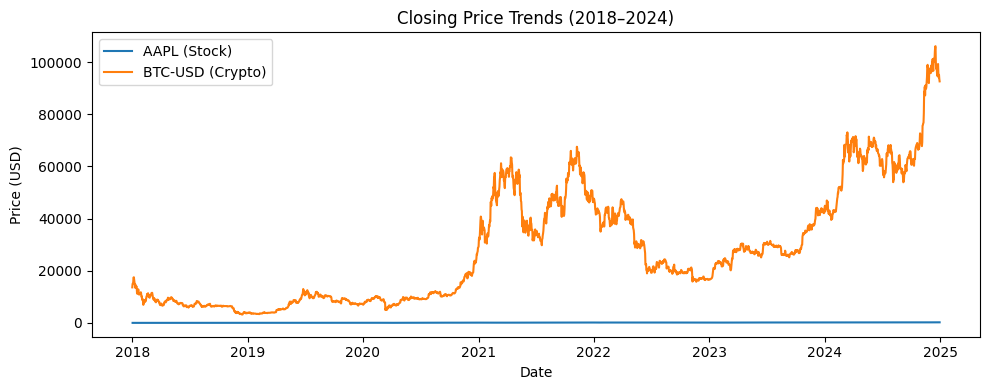

In [7]:
# ==================================
# 2.3 Initial price trend visualisation
# ==================================

plt.figure(figsize=(10, 4))
plt.plot(stock_df["Date"], stock_df["Close"], label="AAPL (Stock)")
plt.plot(crypto_df["Date"], crypto_df["Close"], label="BTC-USD (Crypto)")
plt.title("Closing Price Trends (2018–2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
savefig("fig_raw_price_trends.png")
plt.show()


## 3. Data alignment and pre-processing

Financial time-series data must be aligned before any modelling can take place.
Stock markets operate only on business days, while cryptocurrency markets trade continuously.
As a result, stock and cryptocurrency datasets differ in both length and calendar structure.

To ensure consistency:
- Both datasets are aligned using a shared date index.
- Missing dates resulting from non-trading days are handled carefully.
- Forward-filling is applied to preserve the most recent available market information.
- The aligned dataset is converted into a wide format, enabling unified feature engineering.

This step ensures that all models are trained on a consistent temporal representation,
which is critical for valid comparison between stock and cryptocurrency predictions.


### 3.1 Date Alignment

Stock and cryptocurrency markets operate on different trading schedules. This section aligns the datasets by date to ensure consistency when analysing
cross-market relationships.


In [8]:
# ==================================
# 3.1 Date formatting and sorting
# ==================================

stock_df["Date"] = pd.to_datetime(stock_df["Date"])
crypto_df["Date"] = pd.to_datetime(crypto_df["Date"])

stock_df = stock_df.sort_values("Date")
crypto_df = crypto_df.sort_values("Date")

print("Stock date range:", stock_df["Date"].min(), "to", stock_df["Date"].max())
print("Crypto date range:", crypto_df["Date"].min(), "to", crypto_df["Date"].max())


Stock date range: 2018-01-02 00:00:00 to 2024-12-30 00:00:00
Crypto date range: 2018-01-01 00:00:00 to 2024-12-30 00:00:00


### 3.2 Combined Dataset Construction

This section merges the aligned stock and cryptocurrency datasets into a single time-indexed dataset. The combined dataset enables joint feature engineering and cross-market analysis.


In [9]:
# ==================================
# 3.2 Align stock and crypto data
# ==================================

def align_time_series(stock_df: pd.DataFrame, crypto_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aligns stock and cryptocurrency data on a common date index
    and returns a wide-format DataFrame.
    """

    stock_series = stock_df.set_index("Date")[["Close", "Volume"]]
    crypto_series = crypto_df.set_index("Date")[["Close", "Volume"]]

    stock_series.columns = ["Close_AAPL", "Volume_AAPL"]
    crypto_series.columns = ["Close_BTC", "Volume_BTC"]

    # Outer join to include all dates
    combined = pd.concat([stock_series, crypto_series], axis=1)

    # Forward-fill missing values caused by non-trading days
    combined = combined.ffill()
    return combined

aligned_df = align_time_series(stock_df, crypto_df)

print("Aligned dataset shape:", aligned_df.shape)
aligned_df.head()


Aligned dataset shape: (2556, 4)


,Close_AAPL,Volume_AAPL,Close_BTC,Volume_BTC
Date,,,,
2018-01-01,NaN,NaN,13657.200195,10291200000
2018-01-02,40.341888,102223600.0,14982.099609,16846600192
2018-01-03,40.334869,118071600.0,15201.000000,16871900160
2018-01-04,40.522221,89738400.0,15599.200195,21783199744
2018-01-05,40.983585,94640000.0,17429.500000,23840899072


### 3.3 Data Quality Check After Alignment

Following dataset alignment, additional data quality checks are performed to identify missing values or inconsistencies introduced during the merging process.


In [15]:
# ==================================
# 3.3 Post-alignment data quality
# ==================================

data_quality_report(aligned_df.reset_index(), "Aligned stock-crypto dataset")



DATA QUALITY REPORT: Aligned stock-crypto dataset
Number of rows: 2555
Number of columns: 5

Missing values per column:
Date           0
Close_AAPL     0
Volume_AAPL    0
Close_BTC      0
Volume_BTC     0
dtype: int64

Duplicate rows: 0

Date range:
Start: 2018-01-02 00:00:00
End: 2024-12-30 00:00:00


### 3.4 Aligned Price Visualization

This section visualizes the aligned closing prices for AAPL and BTC-USD to confirm that the datasets are synchronised correctly after preprocessing.


[Saved figure] figures\aligned_price_trends.png


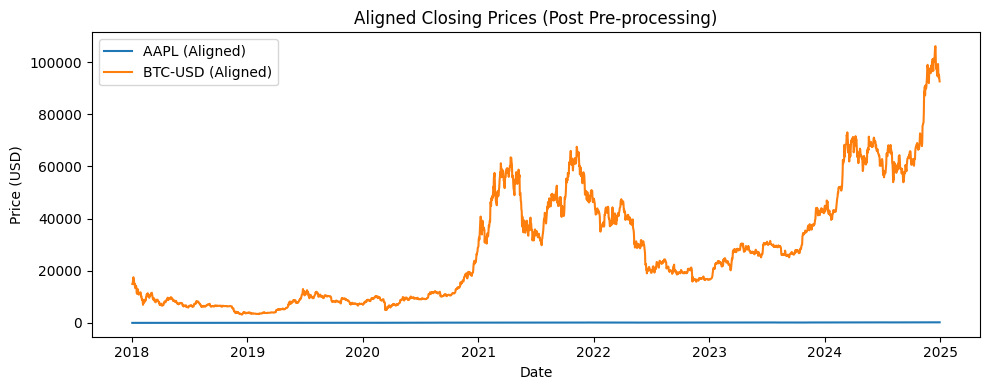

In [16]:
# ==================================
# 3.4 Visual validation of alignment
# ==================================

plt.figure(figsize=(10, 4))
plt.plot(aligned_df.index, aligned_df["Close_AAPL"], label="AAPL (Aligned)")
plt.plot(aligned_df.index, aligned_df["Close_BTC"], label="BTC-USD (Aligned)")
plt.title("Aligned Closing Prices (Post Pre-processing)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
savefig("aligned_price_trends.png")
plt.show()


### 3.5 Feature Correlation Analysis

A correlation heatmap is generated to examine relationships between stock and cryptocurrency features. This analysis provides insight into potential
interdependencies across markets.


In [17]:
# ==================================
# 3.5 Remove initial non-trading day
# ==================================

aligned_df = aligned_df.dropna()

data_quality_report(aligned_df.reset_index(), "Aligned dataset (post-cleaning)")



DATA QUALITY REPORT: Aligned dataset (post-cleaning)
Number of rows: 2555
Number of columns: 5

Missing values per column:
Date           0
Close_AAPL     0
Volume_AAPL    0
Close_BTC      0
Volume_BTC     0
dtype: int64

Duplicate rows: 0

Date range:
Start: 2018-01-02 00:00:00
End: 2024-12-30 00:00:00


## 4. Feature engineering

Raw price data alone is insufficient for effective financial prediction.Machine learning models benefit from engineered features that capture:

- Market trends
- Momentum
- Volatility
- Short-term and medium-term price behaviour

In this section, a set of widely used and technical indicators are constructed for both assets.

The selected features are:
- Simple Moving Average (SMA)
- Exponential Moving Average (EMA)
- Daily returns
- Rolling volatility
- Relative Strength Index (RSI)
- Bollinger Bands
- MACD (trend momentum indicator)

All features are computed using only historical data, avoiding data leakage.


### 4.1 Feature Engineering

This section generates technical indicators for both AAPL and BTC-USD, including moving averages, volatility measures, momentum indicators and trend-based features. These engineered features enhance the models ability to capture market dynamics.


In [19]:
# ==================================
# 4.1 Technical indicator functions
# ==================================

def add_sma(df, col, window):
    df[f"{col}_SMA_{window}"] = df[col].rolling(window).mean()
    return df

def add_ema(df, col, span):
    df[f"{col}_EMA_{span}"] = df[col].ewm(span=span, adjust=False).mean()
    return df

def add_returns(df, col):
    df[f"{col}_RET"] = df[col].pct_change()
    return df

def add_volatility(df, col, window=10):
    df[f"{col}_VOL_{window}"] = df[col].pct_change().rolling(window).std()
    return df

def add_rsi(df, col, window=14):
    delta = df[col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df[f"{col}_RSI_{window}"] = 100 - (100 / (1 + rs))
    return df

def add_bollinger(df, col, window=20, num_std=2):
    mid = df[col].rolling(window).mean()
    std = df[col].rolling(window).std()
    df[f"{col}_BB_MID"] = mid
    df[f"{col}_BB_UP"] = mid + num_std * std
    df[f"{col}_BB_LOW"] = mid - num_std * std
    return df

def add_macd(df, col):
    ema_fast = df[col].ewm(span=12, adjust=False).mean()
    ema_slow = df[col].ewm(span=26, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=9, adjust=False).mean()
    df[f"{col}_MACD"] = macd
    df[f"{col}_MACD_SIGNAL"] = signal
    df[f"{col}_MACD_HIST"] = macd - signal
    return df


### 4.2 Validation of Engineered Features

After feature engineering, data quality checks are repeated to ensure that all newly created features are valid and free from missing values or inconsistencies.


In [20]:
# ==================================
# 4.2 Build feature dataset
# ==================================

features_df = aligned_df.copy()

targets = ["Close_AAPL", "Close_BTC"]

for t in targets:
    features_df = add_sma(features_df, t, 5)
    features_df = add_sma(features_df, t, 10)
    features_df = add_ema(features_df, t, 10)
    features_df = add_returns(features_df, t)
    features_df = add_volatility(features_df, t, 10)
    features_df = add_rsi(features_df, t, 14)
    features_df = add_bollinger(features_df, t)
    features_df = add_macd(features_df, t)

# Remove rows created by rolling calculations
features_df = features_df.dropna()

data_quality_report(features_df.reset_index(), "Feature-engineered dataset")
features_df.head()



DATA QUALITY REPORT: Feature-engineered dataset
Number of rows: 2536
Number of columns: 29

Missing values per column:
Date                      0
Close_AAPL                0
Volume_AAPL               0
Close_BTC                 0
Volume_BTC                0
Close_AAPL_SMA_5          0
Close_AAPL_SMA_10         0
Close_AAPL_EMA_10         0
Close_AAPL_RET            0
Close_AAPL_VOL_10         0
Close_AAPL_RSI_14         0
Close_AAPL_BB_MID         0
Close_AAPL_BB_UP          0
Close_AAPL_BB_LOW         0
Close_AAPL_MACD           0
Close_AAPL_MACD_SIGNAL    0
Close_AAPL_MACD_HIST      0
Close_BTC_SMA_5           0
Close_BTC_SMA_10          0
Close_BTC_EMA_10          0
Close_BTC_RET             0
Close_BTC_VOL_10          0
Close_BTC_RSI_14          0
Close_BTC_BB_MID          0
Close_BTC_BB_UP           0
Close_BTC_BB_LOW          0
Close_BTC_MACD            0
Close_BTC_MACD_SIGNAL     0
Close_BTC_MACD_HIST       0
dtype: int64

Duplicate rows: 0

Date range:
Start: 2018-01-21 00:00

,Close_AAPL,Volume_AAPL,Close_BTC,Volume_BTC,Close_AAPL_SMA_5,Close_AAPL_SMA_10,Close_AAPL_EMA_10,Close_AAPL_RET,Close_AAPL_VOL_10,Close_AAPL_RSI_14,...,Close_BTC_EMA_10,Close_BTC_RET,Close_BTC_VOL_10,Close_BTC_RSI_14,Close_BTC_BB_MID,Close_BTC_BB_UP,Close_BTC_BB_LOW,Close_BTC_MACD,Close_BTC_MACD_SIGNAL,Close_BTC_MACD_HIST
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-21,41.793880,129700400.0,11600.099609,9935179776,41.861328,41.646106,41.600812,0.000000,0.006607,70.893152,...,12604.860853,-0.100712,0.078435,27.947627,14077.714941,17962.784119,10192.645764,-909.093312,-633.395438,-275.697874
2018-01-22,41.451950,108434400.0,10931.400391,10537400320,41.762965,41.643997,41.573746,-0.008181,0.006551,64.576094,...,12300.595314,-0.057646,0.077128,29.660947,13875.179980,17977.973569,9772.386392,-991.916696,-705.099689,-286.817006
2018-01-23,41.461319,130756400.0,10868.400391,9660609536,41.658982,41.642825,41.553305,0.000226,0.006552,64.873089,...,12040.196237,-0.005763,0.075506,31.192726,13658.550000,17921.010401,9396.089599,-1050.528558,-774.185463,-276.343095
2018-01-24,40.800903,204420400.0,11359.400391,9940989952,41.460387,41.575611,41.416504,-0.015928,0.008262,49.705531,...,11916.415174,0.045177,0.078319,31.969271,13446.560010,17724.332962,9168.787058,-1045.309606,-828.410292,-216.899315
2018-01-25,40.072571,166116000.0,11259.400391,8873169920,41.116125,41.435564,41.172153,-0.017851,0.009684,35.118101,...,11796.957941,-0.008803,0.078072,37.453828,13138.055029,17083.424642,9192.685416,-1037.285532,-870.185340,-167.100192


[Saved figure] figures\feature_correlation.png


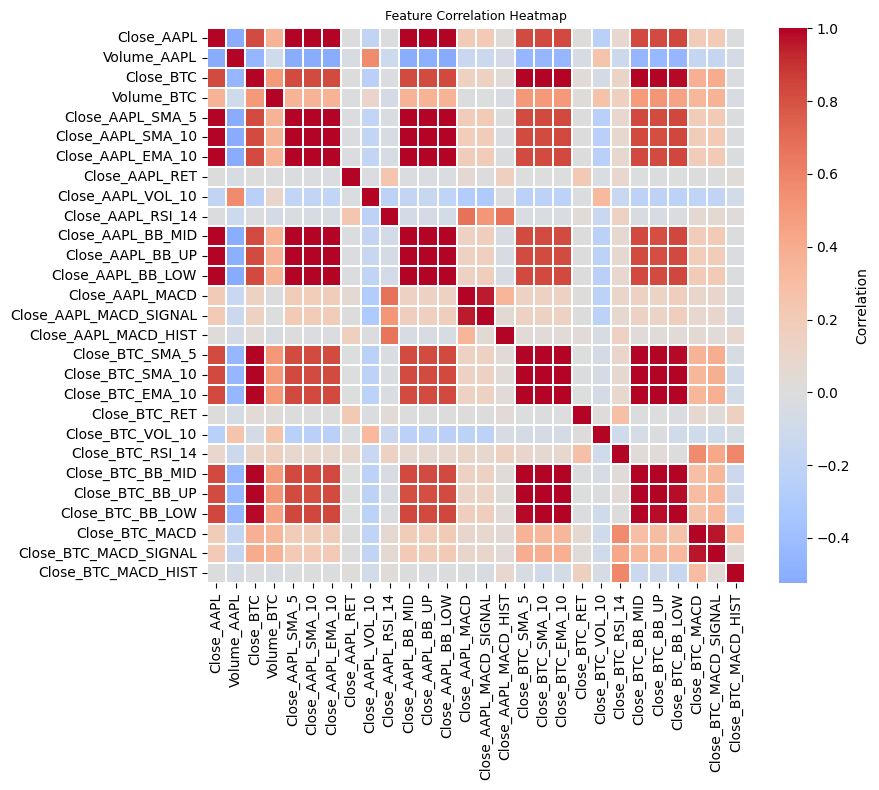

In [21]:
# ==================================
# 4.3 Feature correlation analysis
# ==================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 8))

sns.heatmap(
    features_df.corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar_kws={"label": "Correlation"}
)

plt.title("Feature Correlation Heatmap", fontsize=9)
plt.tight_layout()
savefig("feature_correlation.png")
plt.show()


## 5. Supervised learning setup

After feature engineering, the problem must be formally defined as a supervised machine learning task.

In this project, the objective is to predict the *next-day closing price* based on historical price behaviour and technical indicators.
Although the model outputs a numeric price, the evaluation focuses on *trend prediction*, i.e., whether the model correctly predicts
the direction of price movement (upward or downward).

Key design decisions at this stage include:
- Defining the prediction target using a one-day forecast horizon
- Separating features from target variables
- Performing a *chronological train–test split* to prevent look-ahead bias
- Establishing evaluation metrics appropriate for financial time-series data

This formulation ensures that all models are trained and tested under realistic market conditions.


### 5.1 Target Variable Creation

In this section, the target variables are created for both stock and cryptocurrency datasets. The target represents the next-day closing price, enabling the models to learn one-step-ahead price prediction.


In [22]:
# ==================================
# 5.1 Target variable construction
# ==================================

# Create next-day prediction targets
features_df["Target_AAPL"] = features_df["Close_AAPL"].shift(-1)
features_df["Target_BTC"] = features_df["Close_BTC"].shift(-1)

# Remove last row (no future target available)
features_df = features_df.dropna()

print("Dataset shape after target creation:", features_df.shape)
features_df[["Close_AAPL", "Target_AAPL", "Close_BTC", "Target_BTC"]].head()


Dataset shape after target creation: (2535, 30)


,Close_AAPL,Target_AAPL,Close_BTC,Target_BTC
Date,,,,
2018-01-21,41.793880,41.451950,11600.099609,10931.400391
2018-01-22,41.451950,41.461319,10931.400391,10868.400391
2018-01-23,41.461319,40.800903,10868.400391,11359.400391
2018-01-24,40.800903,40.072571,11359.400391,11259.400391
2018-01-25,40.072571,40.166237,11259.400391,11171.400391


AAPL Direction Distribution:
Direction_AAPL
0    1595
1     940
Name: count, dtype: int64
Percentage going up: 37.08%

BTC Direction Distribution:
Direction_BTC
1    1300
0    1235
Name: count, dtype: int64
Percentage going up: 51.28%
[Saved figure] figures\direction_distribution.png


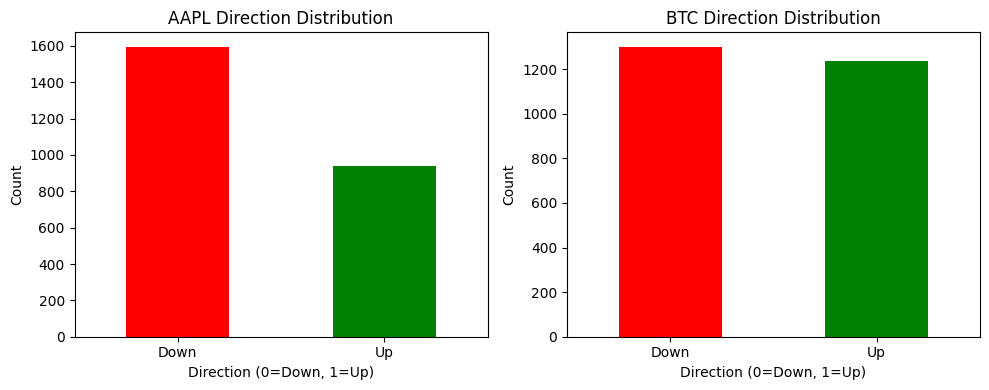

In [23]:
# ==================================
# 5.1.5 Direction Target Creation (NEW)
# ==================================

# Binary classification: 1 = price goes up, 0 = price goes down
features_df["Direction_AAPL"] = (
    features_df["Target_AAPL"] > features_df["Close_AAPL"]
).astype(int)

features_df["Direction_BTC"] = (
    features_df["Target_BTC"] > features_df["Close_BTC"]
).astype(int)

# Check class balance
print("AAPL Direction Distribution:")
print(features_df["Direction_AAPL"].value_counts())
print(f"Percentage going up: {features_df['Direction_AAPL'].mean():.2%}")

print("\nBTC Direction Distribution:")
print(features_df["Direction_BTC"].value_counts())
print(f"Percentage going up: {features_df['Direction_BTC'].mean():.2%}")

# Visualize direction distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

features_df["Direction_AAPL"].value_counts().plot(
    kind='bar', ax=axes[0], color=['red', 'green']
)
axes[0].set_title("AAPL Direction Distribution")
axes[0].set_xlabel("Direction (0=Down, 1=Up)")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(['Down', 'Up'], rotation=0)

features_df["Direction_BTC"].value_counts().plot(
    kind='bar', ax=axes[1], color=['red', 'green']
)
axes[1].set_title("BTC Direction Distribution")
axes[1].set_xlabel("Direction (0=Down, 1=Up)")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(['Down', 'Up'], rotation=0)

plt.tight_layout()
savefig("direction_distribution.png")
plt.show()

### 5.2 Feature and Target Separation

This section separates the dataset into input features and target variables.The features are used as inputs to the machine learning models, while the target variables represent the values to be predicted.


In [17]:
# # ==================================
# # 5.2 Feature and target separation
# # ==================================

# FEATURE_COLUMNS = [
#     col for col in features_df.columns
#     if col not in ["Target_AAPL", "Target_BTC"]
# ]

# X = features_df[FEATURE_COLUMNS]

# y_stock = features_df["Target_AAPL"]
# y_crypto = features_df["Target_BTC"]

# print("Number of features:", X.shape[1])


In [24]:
# ==================================
# 5.2 Feature and target separation 
# ==================================

# Define which columns to EXCLUDE from features
EXCLUDE_COLUMNS = [
    "Target_AAPL", 
    "Target_BTC",
    "Direction_AAPL",   
    "Direction_BTC",     
    "Close_AAPL",     
    "Close_BTC",       
]

FEATURE_COLUMNS = [
    col for col in features_df.columns
    if col not in EXCLUDE_COLUMNS
]

print("Excluded columns:", EXCLUDE_COLUMNS)
print("Number of features:", len(FEATURE_COLUMNS))
print("\nFeatures used:")
for i, col in enumerate(FEATURE_COLUMNS, 1):
    print(f"{i}. {col}")

X = features_df[FEATURE_COLUMNS]
y_stock = features_df["Target_AAPL"]
y_crypto = features_df["Target_BTC"]
y_stock_direction = features_df["Direction_AAPL"]
y_crypto_direction = features_df["Direction_BTC"]

print(f"\nX shape: {X.shape}")
print(f"y_stock shape: {y_stock.shape}")
print(f"y_crypto shape: {y_crypto.shape}")
print("Number of features:", X.shape[1])

Excluded columns: ['Target_AAPL', 'Target_BTC', 'Direction_AAPL', 'Direction_BTC', 'Close_AAPL', 'Close_BTC']
Number of features: 26

Features used:
1. Volume_AAPL
2. Volume_BTC
3. Close_AAPL_SMA_5
4. Close_AAPL_SMA_10
5. Close_AAPL_EMA_10
6. Close_AAPL_RET
7. Close_AAPL_VOL_10
8. Close_AAPL_RSI_14
9. Close_AAPL_BB_MID
10. Close_AAPL_BB_UP
11. Close_AAPL_BB_LOW
12. Close_AAPL_MACD
13. Close_AAPL_MACD_SIGNAL
14. Close_AAPL_MACD_HIST
15. Close_BTC_SMA_5
16. Close_BTC_SMA_10
17. Close_BTC_EMA_10
18. Close_BTC_RET
19. Close_BTC_VOL_10
20. Close_BTC_RSI_14
21. Close_BTC_BB_MID
22. Close_BTC_BB_UP
23. Close_BTC_BB_LOW
24. Close_BTC_MACD
25. Close_BTC_MACD_SIGNAL
26. Close_BTC_MACD_HIST

X shape: (2535, 26)
y_stock shape: (2535,)
y_crypto shape: (2535,)
Number of features: 26


### 5.3 Train and Test Split

The dataset is split into training and testing sets using a time-based approach.This ensures that future data is not used to predict past values and prevents data leakage.


In [19]:
# # ==================================
# # 5.3 Time-aware train-test split
# # ==================================

# def time_series_split(X, y, test_size=0.2):
#     """
#     Splits data chronologically into training and testing sets.
#     """
#     split_idx = int(len(X) * (1 - test_size))
#     X_train = X.iloc[:split_idx]
#     X_test = X.iloc[split_idx:]
#     y_train = y.iloc[:split_idx]
#     y_test = y.iloc[split_idx:]
#     return X_train, X_test, y_train, y_test


# # Stock split
# X_train_stock, X_test_stock, y_train_stock, y_test_stock = time_series_split(
#     X, y_stock, TEST_SIZE
# )

# # Crypto split
# X_train_crypto, X_test_crypto, y_train_crypto, y_test_crypto = time_series_split(
#     X, y_crypto, TEST_SIZE
# )

# print("Stock train size:", X_train_stock.shape)
# print("Stock test size:", X_test_stock.shape)


In [25]:
# ==================================
# 5.3 Time-aware train-test split 
# ==================================

def time_series_split(X, y, y_direction, test_size=0.2):
    """
    Splits data chronologically into training and testing sets.
    Now also splits direction targets.
    """
    split_idx = int(len(X) * (1 - test_size))
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    y_dir_train = y_direction.iloc[:split_idx]
    y_dir_test = y_direction.iloc[split_idx:]
    return X_train, X_test, y_train, y_test, y_dir_train, y_dir_test

# Stock split
(X_train_stock, X_test_stock, 
 y_train_stock, y_test_stock,
 y_train_stock_dir, y_test_stock_dir) = time_series_split(
    X, y_stock, y_stock_direction, TEST_SIZE
)

# Crypto split
(X_train_crypto, X_test_crypto, 
 y_train_crypto, y_test_crypto,
 y_train_crypto_dir, y_test_crypto_dir) = time_series_split(
    X, y_crypto, y_crypto_direction, TEST_SIZE
)

print("Stock train size:", X_train_stock.shape)
print("Stock test size:", X_test_stock.shape)
print(f"Train direction split: {y_train_stock_dir.mean():.2%} up")
print(f"Test direction split: {y_test_stock_dir.mean():.2%} up")

Stock train size: (2028, 26)
Stock test size: (507, 26)
Train direction split: 36.59% up
Test direction split: 39.05% up


### 5.4 Training and Testing Date Validation

This section verifies the date ranges of the training and testing datasets. It ensures that the chronological order of the data is preserved.


In [26]:
# ==================================
# 5.4 Evaluation metrics
# ==================================

def regression_metrics(y_true, y_pred):
    """
    Computes standard regression metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)     
    rmse = np.sqrt(mse)                          
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    return mae, rmse, mape


def directional_accuracy(y_true, y_pred):
    """
    Computes directional accuracy (trend prediction accuracy).
    """
    true_dir = np.sign(y_true.diff().dropna())
    pred_dir = np.sign(pd.Series(y_pred, index=y_true.index).diff().dropna())
    return (true_dir == pred_dir).mean()


### 5.5 Final Dataset Preparation for Modeling

This section confirms that the dataset is fully prepared for model training. The features, targets and splits are validated and ready to be used in
machine learning and deep learning models.


In [27]:
# ==================================
# 5.5 Baseline model training template
# ==================================

def train_random_forest(X_train, y_train, n_estimators=200):
    """
    Trains a Random Forest regressor.
    """
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    return rf


In [28]:
# Checking dates for training and testing
print("First date in training:", X_train_stock.index.min())
print("Last date in training:", X_train_stock.index.max())
print("First date in testing:", X_test_stock.index.min())
print("Last date in testing:", X_test_stock.index.max())


First date in training: 2018-01-21 00:00:00
Last date in training: 2023-08-10 00:00:00
First date in testing: 2023-08-11 00:00:00
Last date in testing: 2024-12-29 00:00:00


## 6 Classical Regression and Baseline Models

Classical regression approaches are implemented as baseline methods. These models establish a
lower-bound benchmark for predictive performance and help assess the degree of non-linearity and temporal complexity present in the data.

The following regression models are considered:
- Linear Regression
- Ridge Regression (L2-regularised linear regression)
- Support Vector Regression (SVR) with RBF kernel

Baseline models provide a point of comparison and help determine whether more complex architectures offer meaningful performance improvements.

The following supervised learning models are implemented:
- Random Forest Regressor
- XGBoost Regressor 

Both models are trained separately on stock and cryptocurrency datasets. Performance is evaluated using both regression metrics and directional accuracy, reflecting the dual objectives of price estimation and trend prediction.

All models are trained using the same chronological train-test split to ensure fair comparison with subsequent models.


### 6.1 Linear Regression – Stock Prediction (AAPL)

Linear Regression is implemented as a simple baseline model that assumes a linear relationship between input features and the target variable. Although
financial markets are inherently non-linear, this model provides a useful reference point for evaluating more complex approaches.


In [29]:

# Linear Regression
lr_stock = LinearRegression()
lr_stock.fit(X_train_stock, y_train_stock)

y_pred_lr_stock = lr_stock.predict(X_test_stock)

mae_lr_stock, rmse_lr_stock, mape_lr_stock = regression_metrics(
    y_test_stock, y_pred_lr_stock
)
dir_acc_lr_stock = directional_accuracy(y_test_stock, y_pred_lr_stock)

print("Linear Regression – AAPL")
print(f"MAE  : {mae_lr_stock:.4f}")
print(f"RMSE : {rmse_lr_stock:.4f}")
print(f"MAPE : {mape_lr_stock:.2f}%")
print(f"Directional Accuracy: {dir_acc_lr_stock:.2%}")


Linear Regression – AAPL
MAE  : 1.6456
RMSE : 2.4128
MAPE : 0.83%
Directional Accuracy: 33.60%


### 6.2 Ridge Regression – Stock Prediction (AAPL)

Ridge Regression extends linear regression by introducing L2 regularisation,which helps mitigate multicollinearity among technical indicators and reduces model variance.


In [30]:
# Ridge Regression

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=SEED))
])

ridge_pipe.fit(X_train_stock, y_train_stock)
y_pred_ridge_stock = ridge_pipe.predict(X_test_stock)

mae_ridge_stock, rmse_ridge_stock, mape_ridge_stock = regression_metrics(y_test_stock, y_pred_ridge_stock)
dir_acc_ridge_stock = directional_accuracy(y_test_stock, y_pred_ridge_stock)

print("Ridge Regression – AAPL")
print(f"MAE  : {mae_ridge_stock:.4f}")
print(f"RMSE : {rmse_ridge_stock:.4f}")
print(f"MAPE : {mape_ridge_stock:.2f}%")
print(f"Directional Accuracy: {dir_acc_ridge_stock:.2%}")


Ridge Regression – AAPL
MAE  : 1.8507
RMSE : 2.5698
MAPE : 0.94%
Directional Accuracy: 35.18%


### 6.3 Support Vector Regression – Stock Prediction (AAPL)

Support Vector Regression (SVR) with an RBF kernel is employed to model non-linear relationships between technical indicators and stock prices.
SVR serves as a strong classical machine learning baseline.


In [31]:

# SVR requires scaling
svr_x_scaler = StandardScaler()
svr_y_scaler = StandardScaler()

X_train_svr = svr_x_scaler.fit_transform(X_train_stock)
X_test_svr = svr_x_scaler.transform(X_test_stock)

y_train_svr = svr_y_scaler.fit_transform(
    y_train_stock.values.reshape(-1, 1)
).ravel()

svr_stock = SVR(kernel="rbf", C=100, gamma="scale", epsilon=0.1)
svr_stock.fit(X_train_svr, y_train_svr)

y_pred_svr_scaled = svr_stock.predict(X_test_svr)
y_pred_svr_stock = svr_y_scaler.inverse_transform(
    y_pred_svr_scaled.reshape(-1, 1)
).ravel()

mae_svr_stock, rmse_svr_stock, mape_svr_stock = regression_metrics(
    y_test_stock, y_pred_svr_stock
)
dir_acc_svr_stock = directional_accuracy(y_test_stock, y_pred_svr_stock)

print("SVR (RBF) – AAPL")
print(f"MAE  : {mae_svr_stock:.4f}")
print(f"RMSE : {rmse_svr_stock:.4f}")
print(f"MAPE : {mape_svr_stock:.2f}%")
print(f"Directional Accuracy: {dir_acc_svr_stock:.2%}")


SVR (RBF) – AAPL
MAE  : 42.0887
RMSE : 56.6509
MAPE : 19.55%
Directional Accuracy: 32.02%


### 6.4 Random Forest Baseline – Stock Prediction

A Random Forest regression model is trained as a baseline for predicting AAPL prices. This model captures nonlinear feature relationships without considering temporal dependencies.


In [32]:
# ==================================
# Random Forest – Stock (AAPL)
# ==================================

rf_stock = train_random_forest(X_train_stock, y_train_stock)

y_pred_rf_stock = rf_stock.predict(X_test_stock)

mae_s, rmse_s, mape_s = regression_metrics(y_test_stock, y_pred_rf_stock)
dir_acc_s = directional_accuracy(y_test_stock, y_pred_rf_stock)

print("Random Forest – AAPL")
print(f"MAE  : {mae_s:.4f}")
print(f"RMSE : {rmse_s:.4f}")
print(f"MAPE : {mape_s:.2f}%")
print(f"Directional Accuracy: {dir_acc_s:.2%}")


Random Forest – AAPL
MAE  : 17.0878
RMSE : 25.0763
MAPE : 7.69%
Directional Accuracy: 33.60%


### 6.5 Random Forest Baseline – Cryptocurrency Prediction

The Random Forest model is applied to BTC-USD data to establish a baseline performance for cryptocurrency price prediction.


In [33]:
# ==================================
# Random Forest – Crypto (BTC)
# ==================================

rf_crypto = train_random_forest(X_train_crypto, y_train_crypto)

y_pred_rf_crypto = rf_crypto.predict(X_test_crypto)

mae_c, rmse_c, mape_c = regression_metrics(y_test_crypto, y_pred_rf_crypto)
dir_acc_c = directional_accuracy(y_test_crypto, y_pred_rf_crypto)

print("Random Forest – BTC-USD")
print(f"MAE  : {mae_c:.4f}")
print(f"RMSE : {rmse_c:.4f}")
print(f"MAPE : {mape_c:.2f}%")
print(f"Directional Accuracy: {dir_acc_c:.2%}")


Random Forest – BTC-USD
MAE  : 5963.7520
RMSE : 11300.4634
MAPE : 7.98%
Directional Accuracy: 45.45%


### 6.6 XGBoost Model – Stock Prediction

An XGBoost regression model is trained for AAPL to compare gradient-boosted trees against Random Forest and deep learning approaches.


In [34]:
# ==================================
# XGBoost baseline 
# ==================================

if XGB_AVAILABLE:
    xgb_stock = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED
    )

    xgb_stock.fit(X_train_stock, y_train_stock)
    y_pred_xgb_stock = xgb_stock.predict(X_test_stock)

    mae_x, rmse_x, mape_x = regression_metrics(y_test_stock, y_pred_xgb_stock)
    dir_acc_x = directional_accuracy(y_test_stock, y_pred_xgb_stock)

    print("XGBoost – AAPL")
    print(f"MAE  : {mae_x:.4f}")
    print(f"RMSE : {rmse_x:.4f}")
    print(f"MAPE : {mape_x:.2f}%")
    print(f"Directional Accuracy: {dir_acc_x:.2%}")


XGBoost – AAPL
MAE  : 17.4562
RMSE : 25.9263
MAPE : 7.82%
Directional Accuracy: 34.19%


### 6.6 Feature Importance Analysis

Feature importance scores from tree-based models are visualized to identify the most influential predictors contributing to price prediction.


[Saved figure] figures\rf_feature_importance.png


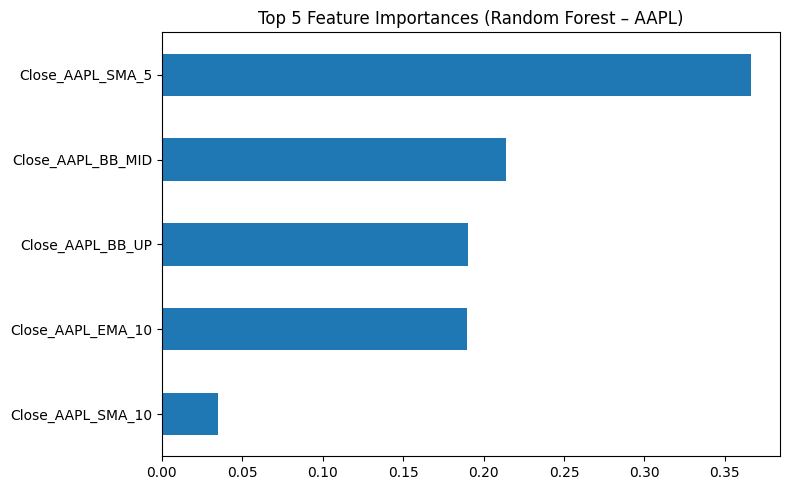

In [35]:
# ==================================
#  Feature importance analysis
# ==================================

importances = pd.Series(
    rf_stock.feature_importances_,
    index=X_train_stock.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
importances.head(5).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 5 Feature Importances (Random Forest – AAPL)")
plt.tight_layout()
savefig("rf_feature_importance.png")
plt.show()


In [46]:
# ==================================
# 6.8 Hyperparameter Optimization (NEW)
# ==================================

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

print("=" * 70)
print("HYPERPARAMETER OPTIMIZATION - RANDOM FOREST")
print("=" * 70)

# Define parameter distribution
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create base model
rf_base = RandomForestRegressor(random_state=SEED, n_jobs=-1)

# Randomized search
print("\nSearching for optimal hyperparameters...")
print("This may take a few minutes...")

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings to try
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

# Fit the random search
random_search.fit(X_train_stock, y_train_stock)

print("\n✓ Optimization complete!")
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation MAE: {-random_search.best_score_:.4f}")

# Train final model with best parameters
rf_optimized = random_search.best_estimator_
y_pred_rf_optimized = rf_optimized.predict(X_test_stock)

# Evaluate
mae_rf_opt, rmse_rf_opt, mape_rf_opt = regression_metrics(
    y_test_stock, y_pred_rf_optimized
)
dir_acc_rf_opt = directional_accuracy(y_test_stock, y_pred_rf_optimized)

print("\nOptimized Random Forest Performance:")
print(f"  MAE:                   {mae_rf_opt:.4f}")
print(f"  RMSE:                  {rmse_rf_opt:.4f}")
print(f"  MAPE:                  {mape_rf_opt:.2f}%")
print(f"  Directional Accuracy:  {dir_acc_rf_opt:.2%}")

print("\nComparison with default parameters:")
print(f"  MAE improvement:       {(1 - mae_rf_opt/mae_rf_stock)*100:.2f}%")
print(f"  RMSE improvement:      {(1 - rmse_rf_opt/rmse_rf_stock)*100:.2f}%")
print(f"  Dir_Acc improvement:   {(dir_acc_rf_opt - dir_acc_rf_stock)*100:.2f} percentage points")



HYPERPARAMETER OPTIMIZATION - RANDOM FOREST

Searching for optimal hyperparameters...
This may take a few minutes...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✓ Optimization complete!

Best parameters found:
  bootstrap: False
  max_depth: 10
  max_features: None
  min_samples_leaf: 3
  min_samples_split: 18
  n_estimators: 491

Best cross-validation MAE: 10.9522

Optimized Random Forest Performance:
  MAE:                   17.0614
  RMSE:                  24.3608
  MAPE:                  7.75%
  Directional Accuracy:  33.00%

Comparison with default parameters:
  MAE improvement:       0.15%
  RMSE improvement:      2.85%
  Dir_Acc improvement:   -0.59 percentage points


[Saved figure] figures\hyperparameter_optimization.png


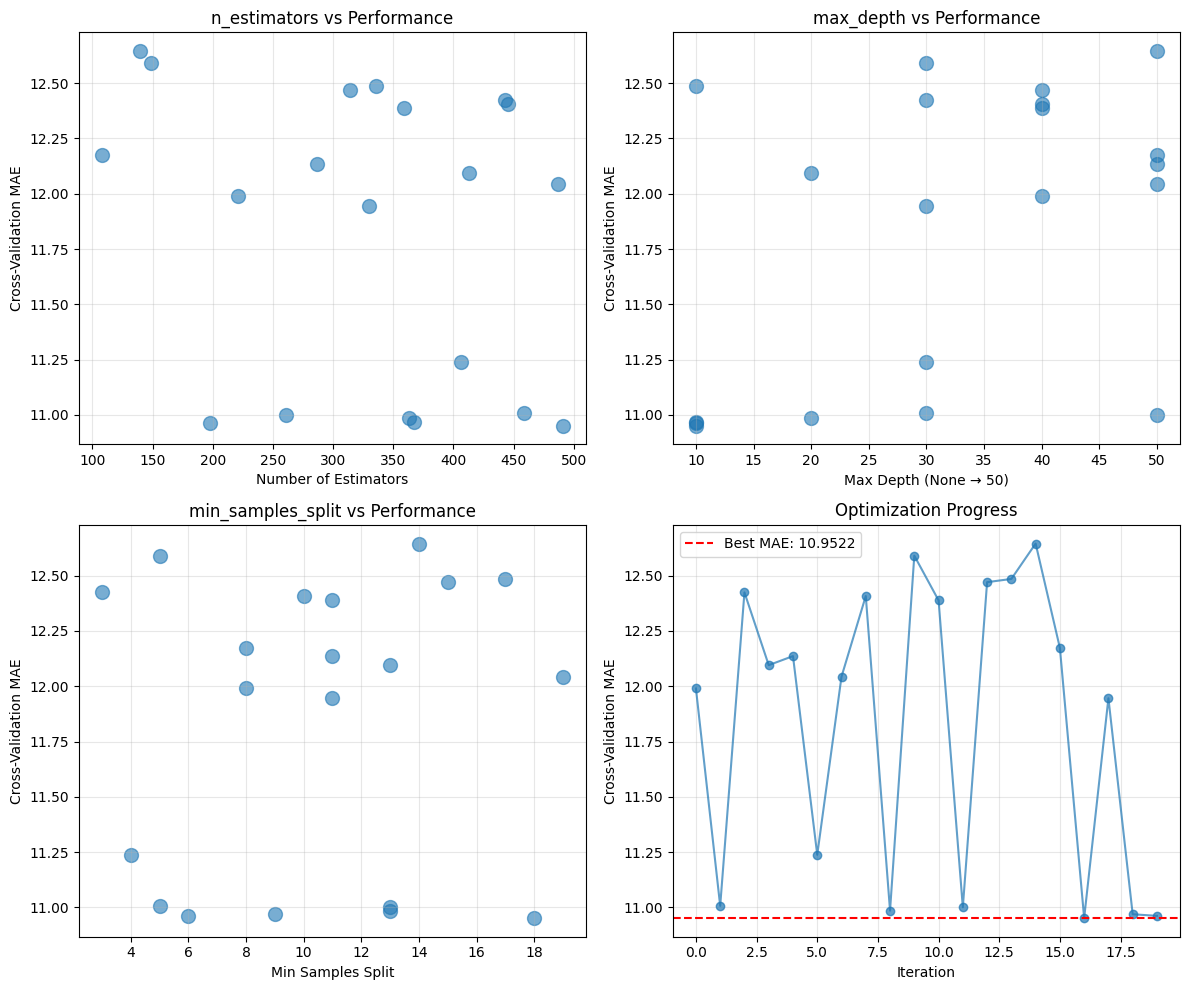

In [47]:
# Visualize hyperparameter search results
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['mean_test_mae'] = -cv_results['mean_test_score']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Number of estimators vs MAE
axes[0, 0].scatter(
    cv_results['param_n_estimators'],
    cv_results['mean_test_mae'],
    alpha=0.6,
    s=100
)
axes[0, 0].set_xlabel('Number of Estimators')
axes[0, 0].set_ylabel('Cross-Validation MAE')
axes[0, 0].set_title('n_estimators vs Performance')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Max depth vs MAE
max_depth_values = [x if x is not None else 50 for x in cv_results['param_max_depth']]
axes[0, 1].scatter(
    max_depth_values,
    cv_results['mean_test_mae'],
    alpha=0.6,
    s=100
)
axes[0, 1].set_xlabel('Max Depth (None → 50)')
axes[0, 1].set_ylabel('Cross-Validation MAE')
axes[0, 1].set_title('max_depth vs Performance')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Min samples split vs MAE
axes[1, 0].scatter(
cv_results['param_min_samples_split'],
cv_results['mean_test_mae'],
alpha=0.6,
s=100
)
axes[1, 0].set_xlabel('Min Samples Split')
axes[1, 0].set_ylabel('Cross-Validation MAE')
axes[1, 0].set_title('min_samples_split vs Performance')
axes[1, 0].grid(alpha=0.3)
# Plot 4: Performance over iterations
axes[1, 1].plot(
range(len(cv_results)),
cv_results['mean_test_mae'],
marker='o',
linestyle='-',
alpha=0.7
)
axes[1, 1].axhline(
y=cv_results['mean_test_mae'].min(),
color='red',
linestyle='--',
label=f'Best MAE: {cv_results["mean_test_mae"].min():.4f}'
)
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Cross-Validation MAE')
axes[1, 1].set_title('Optimization Progress')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
plt.tight_layout()
savefig("hyperparameter_optimization.png")
plt.show()
print("=" * 70)

In [48]:
# ==================================
# Random Forest Classifier for Direction 
# ==================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import seaborn as sns

print("=" * 70)
print("RANDOM FOREST CLASSIFIER - AAPL")
print("=" * 70)

# Train classifier
rf_classifier_stock = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # Handle any class imbalance
    random_state=SEED,
    n_jobs=-1
)

rf_classifier_stock.fit(X_train_stock, y_train_stock_dir)
y_pred_dir_rf_stock = rf_classifier_stock.predict(X_test_stock)
y_pred_proba_rf_stock = rf_classifier_stock.predict_proba(X_test_stock)[:, 1]

# Calculate metrics
acc_rf_stock = accuracy_score(y_test_stock_dir, y_pred_dir_rf_stock)
prec_rf_stock = precision_score(y_test_stock_dir, y_pred_dir_rf_stock)
rec_rf_stock = recall_score(y_test_stock_dir, y_pred_dir_rf_stock)
f1_rf_stock = f1_score(y_test_stock_dir, y_pred_dir_rf_stock)
auc_rf_stock = roc_auc_score(y_test_stock_dir, y_pred_proba_rf_stock)

print(f"Accuracy:  {acc_rf_stock:.2%}")
print(f"Precision: {prec_rf_stock:.2%}")
print(f"Recall:    {rec_rf_stock:.2%}")
print(f"F1-Score:  {f1_rf_stock:.2%}")
print(f"ROC AUC:   {auc_rf_stock:.2%}")

print("\nClassification Report:")
print(classification_report(
    y_test_stock_dir, 
    y_pred_dir_rf_stock,
    target_names=['Down', 'Up']
))


RANDOM FOREST CLASSIFIER - AAPL
Accuracy:  61.74%
Precision: 56.25%
Recall:    9.09%
F1-Score:  15.65%
ROC AUC:   51.52%

Classification Report:
              precision    recall  f1-score   support

        Down       0.62      0.95      0.75       309
          Up       0.56      0.09      0.16       198

    accuracy                           0.62       507
   macro avg       0.59      0.52      0.45       507
weighted avg       0.60      0.62      0.52       507



[Saved figure] figures\rf_classifier_aapl.png


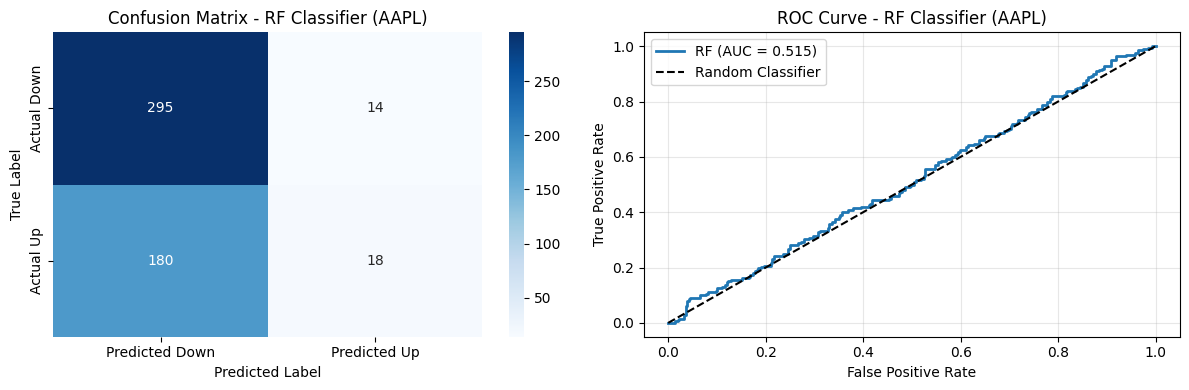


COMPARISON: Regression vs Classification
Regression Model (Directional Accuracy): 33.60%
Classification Model (Accuracy):         61.74%
Improvement: 28.14%


In [49]:
# Confusion Matrix
cm_rf_stock = confusion_matrix(y_test_stock_dir, y_pred_dir_rf_stock)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Confusion Matrix
sns.heatmap(
    cm_rf_stock, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    ax=axes[0],
    xticklabels=['Predicted Down', 'Predicted Up'],
    yticklabels=['Actual Down', 'Actual Up']
)
axes[0].set_title("Confusion Matrix - RF Classifier (AAPL)")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test_stock_dir, y_pred_proba_rf_stock)
axes[1].plot(fpr, tpr, label=f'RF (AUC = {auc_rf_stock:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - RF Classifier (AAPL)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
savefig("rf_classifier_aapl.png")
plt.show()

# Directional accuracy from regression predictions (Random Forest regression)
dir_acc_rf_stock = np.mean(
    np.sign(y_test_stock.values[1:] - y_test_stock.values[:-1]) ==
    np.sign(y_pred_rf_stock[1:] - y_pred_rf_stock[:-1])
)

# Compare with regression directional accuracy
print("\n" + "=" * 70)
print("COMPARISON: Regression vs Classification")
print("=" * 70)
print(f"Regression Model (Directional Accuracy): {dir_acc_rf_stock:.2%}")
print(f"Classification Model (Accuracy):         {acc_rf_stock:.2%}")
print(f"Improvement: {(acc_rf_stock - dir_acc_rf_stock):.2%}")
print("=" * 70)

In [50]:
# ==================================
# 6.10 Random Forest Classifier - BTC 
# ==================================

print("\n" + "=" * 70)
print("RANDOM FOREST CLASSIFIER - BTC-USD")
print("=" * 70)

rf_classifier_crypto = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

rf_classifier_crypto.fit(X_train_crypto, y_train_crypto_dir)
y_pred_dir_rf_crypto = rf_classifier_crypto.predict(X_test_crypto)
y_pred_proba_rf_crypto = rf_classifier_crypto.predict_proba(X_test_crypto)[:, 1]

acc_rf_crypto = accuracy_score(y_test_crypto_dir, y_pred_dir_rf_crypto)
prec_rf_crypto = precision_score(y_test_crypto_dir, y_pred_dir_rf_crypto)
rec_rf_crypto = recall_score(y_test_crypto_dir, y_pred_dir_rf_crypto)
f1_rf_crypto = f1_score(y_test_crypto_dir, y_pred_dir_rf_crypto)
auc_rf_crypto = roc_auc_score(y_test_crypto_dir, y_pred_proba_rf_crypto)

print(f"Accuracy:  {acc_rf_crypto:.2%}")
print(f"Precision: {prec_rf_crypto:.2%}")
print(f"Recall:    {rec_rf_crypto:.2%}")
print(f"F1-Score:  {f1_rf_crypto:.2%}")
print(f"ROC AUC:   {auc_rf_crypto:.2%}")

print("\nClassification Report:")
print(classification_report(
    y_test_crypto_dir, 
    y_pred_dir_rf_crypto,
    target_names=['Down', 'Up']
))


RANDOM FOREST CLASSIFIER - BTC-USD
Accuracy:  48.92%
Precision: 55.00%
Recall:    8.37%
F1-Score:  14.52%
ROC AUC:   52.05%

Classification Report:
              precision    recall  f1-score   support

        Down       0.48      0.93      0.64       244
          Up       0.55      0.08      0.15       263

    accuracy                           0.49       507
   macro avg       0.52      0.50      0.39       507
weighted avg       0.52      0.49      0.38       507



## 7. LSTM model development

Traditional machine learning models treat observations as independent samples and therefore struggle to capture temporal dependencies present in financial time-series data.

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network designed to learn sequential patterns over time.They are particularly well-suited for financial forecasting tasks where historical price movements influence future behaviour.

In this section, LSTM models are developed to predict next-day prices for:
- Apple Inc. (AAPL)
- Bitcoin (BTC-USD)

Key steps include:
- Feature scaling
- Sequence construction using a fixed lookback window
- LSTM model architecture design
- Model training with validation
- Performance evaluation on unseen test data


### 7.1 Data Scaling for LSTM

This section applies feature scaling to ensure that input variables are within a similar numerical range, which is critical for stable LSTM training.


In [51]:
# ==================================
# 7.1 Feature scaling for LSTM
# ==================================

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(X_train_stock)
X_test_scaled  = x_scaler.transform(X_test_stock)

# y must be 2D for scaler
y_train_scaled = y_scaler.fit_transform(y_train_stock.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test_stock.values.reshape(-1, 1))

print("X_train_scaled:", X_train_scaled.shape)
print("y_train_scaled:", y_train_scaled.shape)


X_train_scaled: (2028, 26)
y_train_scaled: (2028, 1)


### 7.2 LSTM Sequence Preparation

Input data is converted into rolling time-window sequences to enable the LSTM model to learn temporal dependencies in the financial time series.


In [52]:
# ==================================
# 7.2 Create LSTM sequences
# ==================================

def create_sequences_xy(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])  # scaled target
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences_xy(X_train_scaled, y_train_scaled, LOOKBACK_WINDOW)
X_test_seq, y_test_seq   = create_sequences_xy(X_test_scaled,  y_test_scaled,  LOOKBACK_WINDOW)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Test seq :", X_test_seq.shape, y_test_seq.shape)


Train seq: (1998, 30, 26) (1998, 1)
Test seq : (477, 30, 26) (477, 1)


### 7.3 LSTM Model Architecture

An LSTM neural network is defined to model sequential dependencies in stock price data. The architecture includes dropout regularisation to mitigate overfitting.


In [56]:
# ==================================
# 7.3 LSTM model architecture
# ==================================

def build_lstm(input_shape):
    """
    Builds a LSTM regression model.
    """
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer="adam",
        loss="mse"
    )
    return model

lstm_model = build_lstm(
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
)

lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                23296     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23361 (91.25 KB)
Trainable params: 23361 (91.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 7.4 LSTM Model Training

The LSTM model is trained using the prepared sequences. Training and validation losses are monitored to assess convergence and generalisation performance.


In [54]:
# ==================================
# 7.4 Train LSTM model
# ==================================

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/30

50/50 [==============================] - 4s 27ms/step - loss: 0.0121 - val_loss: 0.0065 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 0.0016 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0010 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 0.0014 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0010 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 8/30
50/50 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 7.4673e-04 - lr: 5.0000e-04
Epoch 9/30
50/50 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss:

### 7.5 LSTM Model Evaluation

The trained LSTM model is evaluated on the test dataset using multiple error metrics and directional accuracy to assess predictive performance.


In [57]:
# ==================================
# 7.5 Evaluate LSTM performance
# ==================================

y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# Inverse transform back to price scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mae_l, rmse_l, mape_l = regression_metrics(pd.Series(y_true), y_pred)
dir_acc_l = directional_accuracy(pd.Series(y_true), y_pred)

print("LSTM – AAPL (fixed scaling)")
print(f"MAE  : {mae_l:.4f}")
print(f"RMSE : {rmse_l:.4f}")
print(f"MAPE : {mape_l:.2f}%")
print(f"Directional Accuracy: {dir_acc_l:.2%}")


15/15 [==============================] - 1s 5ms/step
LSTM – AAPL (fixed scaling)
MAE  : 197.1330
RMSE : 198.2247
MAPE : 99.09%
Directional Accuracy: 33.19%


In [58]:
# ==================================
# LSTM Classifier for Direction 
# ==================================

print("=" * 70)
print("LSTM CLASSIFIER - AAPL")
print("=" * 70)

# Need to create sequences for direction labels
def create_sequences_classification(X, y_direction, lookback):
    """
    Creates sequences for classification task.
    y_direction should be binary labels (0 or 1).
    """
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y_direction[i])  # Binary label
    return np.array(X_seq), np.array(y_seq)

# Convert direction labels to numpy arrays
y_train_dir_arr = y_train_stock_dir.values
y_test_dir_arr = y_test_stock_dir.values

# Create sequences (reuse scaled data from Section 7.1)
X_train_seq_clf, y_train_seq_clf = create_sequences_classification(
    X_train_scaled, y_train_dir_arr, LOOKBACK_WINDOW
)
X_test_seq_clf, y_test_seq_clf = create_sequences_classification(
    X_test_scaled, y_test_dir_arr, LOOKBACK_WINDOW
)

print(f"Train sequences: {X_train_seq_clf.shape}, {y_train_seq_clf.shape}")
print(f"Test sequences:  {X_test_seq_clf.shape}, {y_test_seq_clf.shape}")

# Build LSTM Classifier
def build_lstm_classifier(input_shape):
    """
    Builds LSTM binary classifier.
    """
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # ← Sigmoid for binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # ← Binary crossentropy for classification
        metrics=['accuracy']
    )
    return model

lstm_classifier = build_lstm_classifier(
    input_shape=(X_train_seq_clf.shape[1], X_train_seq_clf.shape[2])
)
lstm_classifier.summary()

# Train LSTM Classifier
history_clf = lstm_classifier.fit(
    X_train_seq_clf,
    y_train_seq_clf,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


LSTM CLASSIFIER - AAPL
Train sequences: (1998, 30, 26), (1998,)
Test sequences:  (477, 30, 26), (477,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                23296     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 25409 (99.25 KB)
Trainable params: 25409 (99.25 KB)
Non-trainable par

15/15 [==============================] - 1s 5ms/step

LSTM Classifier Results:
Accuracy:  61.22%
Precision: 0.00%
Recall:    0.00%
F1-Score:  0.00%
ROC AUC:   48.69%

Classification Report:
              precision    recall  f1-score   support

        Down       0.61      1.00      0.76       292
          Up       0.00      0.00      0.00       185

    accuracy                           0.61       477
   macro avg       0.31      0.50      0.38       477
weighted avg       0.37      0.61      0.46       477

[Saved figure] figures\lstm_classifier_training.png


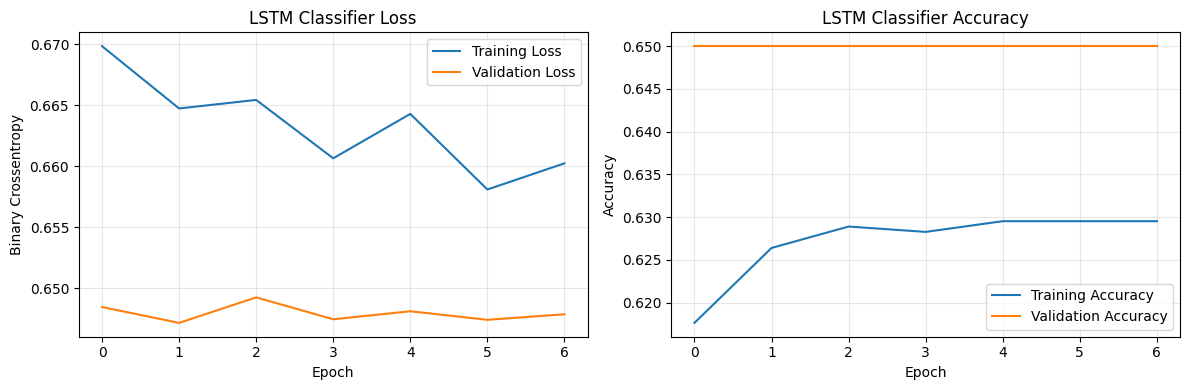

In [59]:
# Evaluate
y_pred_proba_lstm = lstm_classifier.predict(X_test_seq_clf).flatten()
y_pred_dir_lstm = (y_pred_proba_lstm > 0.5).astype(int)

acc_lstm_clf = accuracy_score(y_test_seq_clf, y_pred_dir_lstm)
prec_lstm_clf = precision_score(y_test_seq_clf, y_pred_dir_lstm)
rec_lstm_clf = recall_score(y_test_seq_clf, y_pred_dir_lstm)
f1_lstm_clf = f1_score(y_test_seq_clf, y_pred_dir_lstm)
auc_lstm_clf = roc_auc_score(y_test_seq_clf, y_pred_proba_lstm)

print("\nLSTM Classifier Results:")
print(f"Accuracy:  {acc_lstm_clf:.2%}")
print(f"Precision: {prec_lstm_clf:.2%}")
print(f"Recall:    {rec_lstm_clf:.2%}")
print(f"F1-Score:  {f1_lstm_clf:.2%}")
print(f"ROC AUC:   {auc_lstm_clf:.2%}")

print("\nClassification Report:")
print(classification_report(
    y_test_seq_clf, 
    y_pred_dir_lstm,
    target_names=['Down', 'Up']
))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history_clf.history['loss'], label='Training Loss')
axes[0].plot(history_clf.history['val_loss'], label='Validation Loss')
axes[0].set_title('LSTM Classifier Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Crossentropy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_clf.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_clf.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('LSTM Classifier Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
savefig("lstm_classifier_training.png")
plt.show()

In [60]:
# Alias LSTM regression outputs for consistency in later sections
y_pred_lstm = y_pred
y_true_lstm = y_true


[Saved figure] figures\lstm_training_loss.png


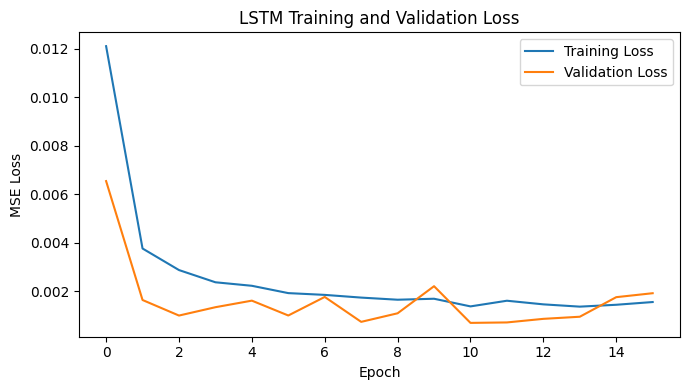

In [61]:
# ==================================
#  LSTM training loss plot
# ==================================

plt.figure(figsize=(7, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
savefig("lstm_training_loss.png")
plt.show()

## 8. Hybrid RF → LSTM model

A hybrid modelling strategy is used to combine the strengths of tree-based feature selection and sequence-based deep learning.

- Random Forest models are effective at identifying informative features using feature importance measures.
- LSTMs are effective at learning sequential patterns over time, but they may perform poorly if trained on noisy or redundant features.

This hybrid approach proceeds in two stages:

1. Train a Random Forest model on the training set.
2. Select the top N features based on feature importances.
3. Train an LSTM model using only these selected features.

This design improves interpretability and can enhance performance by reducing input dimensionality and limiting noise in the LSTM learning process.


### 8.1 Feature Selection Using Random Forest

Random Forest feature importance is used to select a reduced subset of influential features. This step aims to improve LSTM efficiency and reduce noise.


In [62]:
# ==================================
# 8.1 Select top features using RF importance (AAPL)
# ==================================

def get_top_features_from_rf(rf_model, feature_names, top_n=5):
    """
    Returns top_n feature names based on Random Forest feature importances.
    """
    imp = pd.Series(rf_model.feature_importances_, index=feature_names)
    top_features = imp.sort_values(ascending=False).head(top_n).index.tolist()
    return top_features, imp.sort_values(ascending=False)

TOP_N = 5

top_features_aapl, full_importance_aapl = get_top_features_from_rf(
    rf_stock, X_train_stock.columns, top_n=TOP_N
)

print("Top features (AAPL):")
for i, f in enumerate(top_features_aapl, start=1):
    print(f"{i}. {f}")


Top features (AAPL):
1. Close_AAPL_SMA_5
2. Close_AAPL_BB_MID
3. Close_AAPL_BB_UP
4. Close_AAPL_EMA_10
5. Close_AAPL_SMA_10


### 8.2 Reduced Feature Dataset Preparation

The dataset is reconstructed using only the selected top features, preparing it for hybrid model training.


In [63]:
# ==================================
# 8.2 Reduce dataset to top features + scale X and y
# ==================================

# Use only selected top features
X_train_top = X_train_stock[top_features_aapl]
X_test_top  = X_test_stock[top_features_aapl]

# Scale X and y (train only fit → test transform)
x_scaler_h = MinMaxScaler()
y_scaler_h = MinMaxScaler()

X_train_top_scaled = x_scaler_h.fit_transform(X_train_top)
X_test_top_scaled  = x_scaler_h.transform(X_test_top)

y_train_h_scaled = y_scaler_h.fit_transform(y_train_stock.values.reshape(-1, 1))
y_test_h_scaled  = y_scaler_h.transform(y_test_stock.values.reshape(-1, 1))

print("Reduced X_train shape:", X_train_top_scaled.shape)
print("Reduced X_test shape:", X_test_top_scaled.shape)


Reduced X_train shape: (2028, 5)
Reduced X_test shape: (507, 5)


### 8.3 Hybrid Model Sequence Preparation

Time-series sequences are generated from the reduced feature set for training the hybrid RF→LSTM model.


In [64]:
# ==================================
# 8.3 Create sequences for hybrid LSTM
# ==================================

X_train_h_seq, y_train_h_seq = create_sequences_xy(
    X_train_top_scaled, y_train_h_scaled, LOOKBACK_WINDOW
)

X_test_h_seq, y_test_h_seq = create_sequences_xy(
    X_test_top_scaled, y_test_h_scaled, LOOKBACK_WINDOW
)

print("Hybrid train sequences:", X_train_h_seq.shape, y_train_h_seq.shape)
print("Hybrid test sequences :", X_test_h_seq.shape, y_test_h_seq.shape)


Hybrid train sequences: (1998, 30, 5) (1998, 1)
Hybrid test sequences : (477, 30, 5) (477, 1)


### 8.4 Hybrid RF→LSTM Model Training

The hybrid model is trained using the selected features and LSTM architecture.Training behaviour is monitored through loss curves.


In [65]:
# ==================================
# 8.4 Build + train hybrid LSTM model
# ==================================

hybrid_lstm = build_lstm(
    input_shape=(X_train_h_seq.shape[1], X_train_h_seq.shape[2])
)

hybrid_lstm.summary()

history_hybrid = hybrid_lstm.fit(
    X_train_h_seq,
    y_train_h_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17985 (70.25 KB)
Trainable params: 17985 (70.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 4s 32ms/step - loss: 0.0187 - val_loss: 0.0057 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0028 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 1s 13m

### 8.5 Hybrid Model Evaluation – Stock

The hybrid RF→LSTM model is evaluated on AAPL test data and compared against baseline models to quantify performance improvements.


In [66]:
# ==================================
# 8.5 Evaluate hybrid RF → LSTM model
# ==================================

y_pred_h_scaled = hybrid_lstm.predict(X_test_h_seq).flatten()

# Inverse scale predictions back to real prices
y_pred_h = y_scaler_h.inverse_transform(y_pred_h_scaled.reshape(-1, 1)).flatten()
y_true_h = y_scaler_h.inverse_transform(y_test_h_seq.reshape(-1, 1)).flatten()

mae_h, rmse_h, mape_h = regression_metrics(pd.Series(y_true_h), y_pred_h)
dir_acc_h = directional_accuracy(pd.Series(y_true_h), y_pred_h)

print("Hybrid RF → LSTM – AAPL")
print(f"MAE  : {mae_h:.4f}")
print(f"RMSE : {rmse_h:.4f}")
print(f"MAPE : {mape_h:.2f}%")
print(f"Directional Accuracy: {dir_acc_h:.2%}")


15/15 [==============================] - 1s 6ms/step
Hybrid RF → LSTM – AAPL
MAE  : 7.6100
RMSE : 9.6183
MAPE : 3.62%
Directional Accuracy: 35.92%


[Saved figure] figures\hybrid_lstm_loss_aapl.png


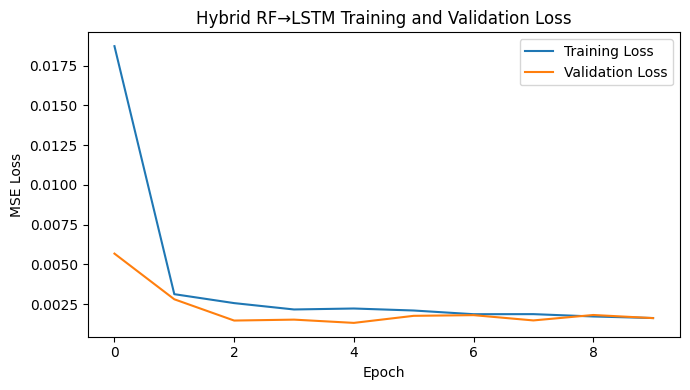

In [67]:
# ==================================
# 8.6 Hybrid training loss curve
# ==================================

plt.figure(figsize=(7, 4))
plt.plot(history_hybrid.history["loss"], label="Training Loss")
plt.plot(history_hybrid.history["val_loss"], label="Validation Loss")
plt.title("Hybrid RF→LSTM Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
savefig("hybrid_lstm_loss_aapl.png")
plt.show()


## 9. Model evaluation and visual diagnostics

Quantitative metrics alone are insufficient to fully assess forecasting models.
Therefore, visual diagnostic tools are employed to evaluate prediction quality, error behaviour and model stability.

This section presents:
- Actual vs predicted price plots
- Residual diagnostics
- Error distribution analysis
- Comparative performance summary across models

These visualisations support interpretability and provide empirical evidence for the effectiveness of the proposed hybrid model.


### 9.1 Actual vs Predicted Price Comparison

This section visualizes the actual and predicted stock prices over time to assess how well the hybrid model captures market dynamics.


[Saved figure] figures\actual_vs_predicted_aapl.png


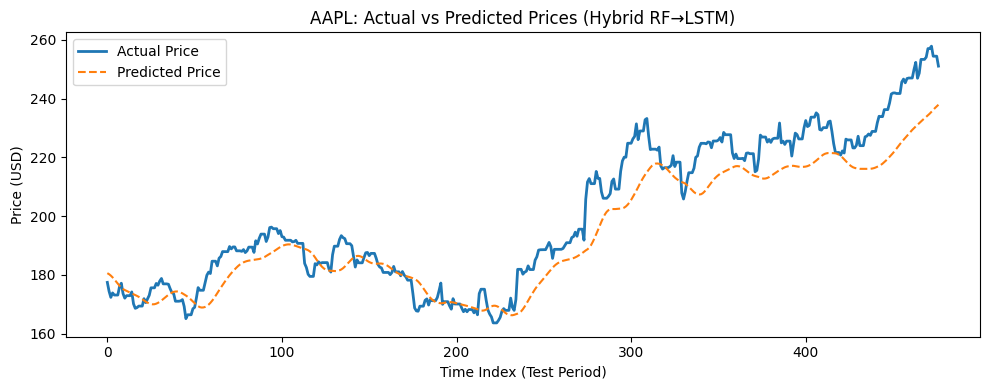

In [68]:
# ==================================
# 9.1 Actual vs Predicted (Hybrid – AAPL)
# ==================================

plt.figure(figsize=(10, 4))
plt.plot(y_true_h, label="Actual Price", linewidth=2)
plt.plot(y_pred_h, label="Predicted Price", linestyle="--")
plt.title("AAPL: Actual vs Predicted Prices (Hybrid RF→LSTM)")
plt.xlabel("Time Index (Test Period)")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
savefig("actual_vs_predicted_aapl.png")
plt.show()


### 9.2 Scatter Plot of Actual vs Predicted Prices

A scatter plot is generated to examine the agreement between actual and predicted prices and identify potential systematic biases.


[Saved figure] figures\scatter_aapl.png


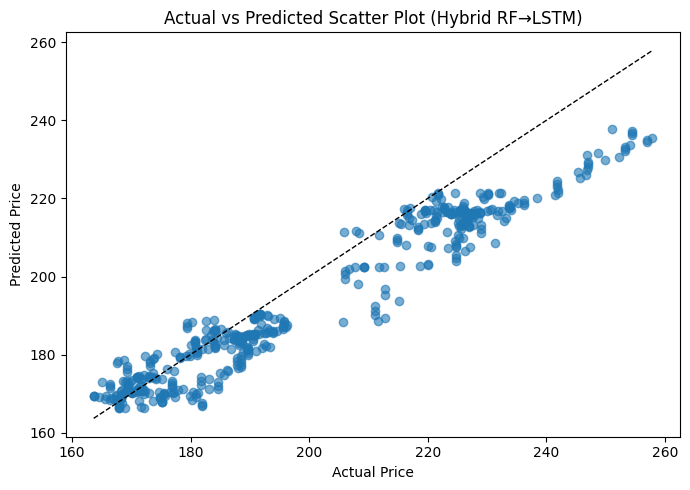

In [69]:
# ==================================
# 9.2 Scatter plot (Hybrid – AAPL)
# ==================================

plt.figure(figsize=(7, 5))
plt.scatter(y_true_h, y_pred_h, alpha=0.6)
min_val = min(y_true_h.min(), y_pred_h.min())
max_val = max(y_true_h.max(), y_pred_h.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Scatter Plot (Hybrid RF→LSTM)")
plt.tight_layout()
savefig("scatter_aapl.png")
plt.show()


### 9.3 Residual Analysis

Residuals are analysed over time to evaluate prediction errors and detect systematic patterns or model bias.


[Saved figure] figures\residuals_aapl.png


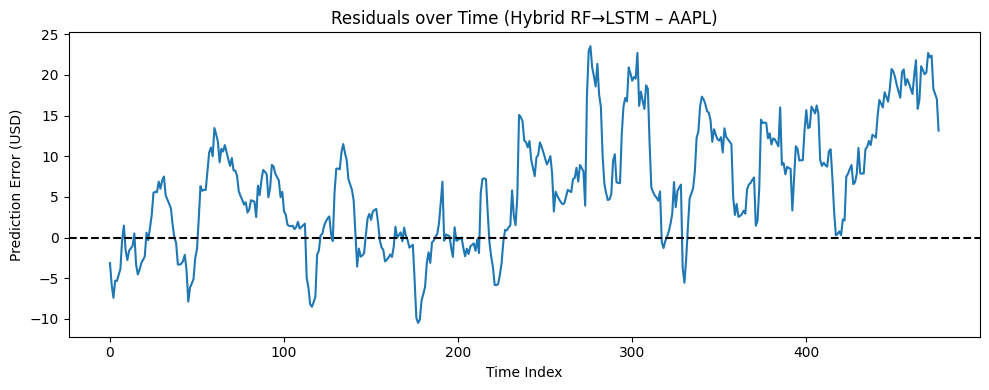

In [70]:
# ==================================
# 9.3 Residual analysis (Hybrid – AAPL)
# ==================================

residuals_h = y_true_h - y_pred_h

plt.figure(figsize=(10, 4))
plt.plot(residuals_h)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals over Time (Hybrid RF→LSTM – AAPL)")
plt.xlabel("Time Index")
plt.ylabel("Prediction Error (USD)")
plt.tight_layout()
savefig("residuals_aapl.png")
plt.show()


### 9.4 Error Distribution Analysis

The distribution of prediction errors is examined to assess the stability and robustness of the hybrid model.


[Saved figure] figures\error_distribution_aapl.png


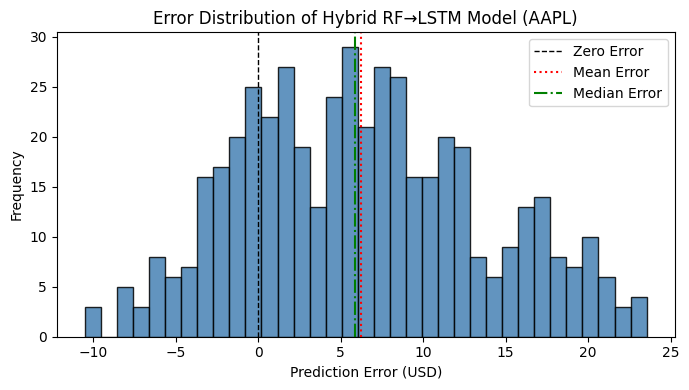

In [71]:
# ==================================
# 9.4 Error distribution (Hybrid – AAPL)
# ==================================


plt.figure(figsize=(7, 4))
plt.hist(
    residuals_h,
    bins=35,
    color="steelblue",
    edgecolor="black",
    alpha=0.85
)

# Reference lines
plt.axvline(0, color="black", linestyle="--", linewidth=1, label="Zero Error")
plt.axvline(
    residuals_h.mean(),
    color="red",
    linestyle=":",
    linewidth=1.5,
    label="Mean Error"
)
plt.axvline(
    np.median(residuals_h),
    color="green",
    linestyle="-.",
    linewidth=1.5,
    label="Median Error"
)

plt.title("Error Distribution of Hybrid RF→LSTM Model (AAPL)")
plt.xlabel("Prediction Error (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
savefig("error_distribution_aapl.png")
plt.show()


### 9.5 Model Performance Comparison

This section compares all implemented models using quantitative evaluation metrics to identify the best-performing approach.


In [72]:
# ==================================
# 9.5 Store evaluation metrics explicitly
# ==================================

# Random Forest – AAPL
mae_rf_stock, rmse_rf_stock, mape_rf_stock = regression_metrics(y_test_stock, y_pred_rf_stock)
dir_acc_rf_stock = directional_accuracy(y_test_stock, y_pred_rf_stock)

# XGBoost – AAPL
mae_xgb_stock, rmse_xgb_stock, mape_xgb_stock = regression_metrics(y_test_stock, y_pred_xgb_stock)
dir_acc_xgb_stock = directional_accuracy(y_test_stock, y_pred_xgb_stock)

# LSTM – AAPL
mae_l = mae_l
rmse_l = rmse_l
mape_l = mape_l
dir_acc_l = dir_acc_l

# Hybrid RF → LSTM – AAPL
mae_h = mae_h
rmse_h = rmse_h
mape_h = mape_h
dir_acc_h = dir_acc_h


In [76]:
# ==================================
# 9.7 Trading Simulation
# ==================================

def backtest_trading_strategy(
    actual_prices, 
    predictions, 
    initial_capital=10000,
    transaction_cost=0.001,
    strategy_type='regression'
):
    """
    Simulates realistic trading based on model predictions.
    
    Parameters:
    -----------
    actual_prices : array-like
        Actual closing prices
    predictions : array-like
        Model predictions (prices for regression, probabilities for classification)
    initial_capital : float
        Starting capital in USD
    transaction_cost : float
        Transaction cost as percentage (0.001 = 0.1%)
    strategy_type : str
        'regression' or 'classification'
    
    Returns:
    --------
    dict : Trading results and metrics
    """
    capital = initial_capital
    shares = 0
    position_value = 0
    
    portfolio_values = []
    trades = []
    
    for i in range(len(actual_prices) - 1):
        current_price = actual_prices[i]
        next_price = actual_prices[i + 1]
        
        # Generate trading signal
        if strategy_type == 'regression':
            # Buy if predicting price increase
            signal = 'buy' if predictions[i + 1] > current_price else 'sell'
        else:  # classification
            # Buy if predicting up movement (probability > 0.5)
            signal = 'buy' if predictions[i] > 0.5 else 'sell'
        
        # Execute trade
        if signal == 'buy' and capital > 0 and shares == 0:
            # Buy shares
            cost_per_share = current_price * (1 + transaction_cost)
            shares = capital / cost_per_share
            capital = 0
            trades.append({
                'day': i,
                'action': 'BUY',
                'price': current_price,
                'shares': shares,
                'cost': cost_per_share * shares
            })
            
        elif signal == 'sell' and shares > 0:
            # Sell shares
            revenue_per_share = current_price * (1 - transaction_cost)
            capital = shares * revenue_per_share
            trades.append({
                'day': i,
                'action': 'SELL',
                'price': current_price,
                'shares': shares,
                'revenue': capital
            })
            shares = 0
        
        # Calculate portfolio value
        if shares > 0:
            position_value = shares * current_price
        else:
            position_value = capital
        
        portfolio_values.append(position_value)
    
    # Final liquidation
    if shares > 0:
        final_price = actual_prices[-1]
        capital = shares * final_price * (1 - transaction_cost)
        shares = 0
    
    final_value = capital
    portfolio_values.append(final_value)
    
    # Calculate metrics
    total_return = (final_value / initial_capital - 1) * 100
    
    # Buy and hold comparison
    buy_hold_shares = initial_capital / (actual_prices[0] * (1 + transaction_cost))
    buy_hold_final = buy_hold_shares * actual_prices[-1] * (1 - transaction_cost)
    buy_hold_return = (buy_hold_final / initial_capital - 1) * 100
    
    # Calculate Sharpe ratio
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe_ratio = np.mean(portfolio_returns) / (np.std(portfolio_returns) + 1e-9) * np.sqrt(252)
    
    # Calculate maximum drawdown
    portfolio_values_arr = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values_arr)
    drawdown = (portfolio_values_arr - running_max) / running_max
    max_drawdown = np.min(drawdown) * 100
    
    return {
        'Initial Capital': initial_capital,
        'Final Value': final_value,
        'Total Return (%)': total_return,
        'Buy & Hold Return (%)': buy_hold_return,
        'Excess Return (%)': total_return - buy_hold_return,
        'Number of Trades': len(trades),
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Portfolio Values': portfolio_values,
        'Trades': trades
    }



In [77]:
# Test with Hybrid RF→LSTM model (regression)
print("=" * 70)
print("TRADING SIMULATION - HYBRID RF→LSTM (Regression)")
print("=" * 70)

# Need to align predictions with actual prices
# y_true_h has 477 values, y_pred_h has 477 values
trading_results_regression = backtest_trading_strategy(
    actual_prices=y_true_h,
    predictions=y_pred_h,
    initial_capital=10000,
    transaction_cost=0.001,
    strategy_type='regression'
)

print(f"Initial Capital:      ${trading_results_regression['Initial Capital']:,.2f}")
print(f"Final Value:          ${trading_results_regression['Final Value']:,.2f}")
print(f"Total Return:         {trading_results_regression['Total Return (%)']:.2f}%")
print(f"Buy & Hold Return:    {trading_results_regression['Buy & Hold Return (%)']:.2f}%")
print(f"Excess Return:        {trading_results_regression['Excess Return (%)']:.2f}%")
print(f"Number of Trades:     {trading_results_regression['Number of Trades']}")
print(f"Sharpe Ratio:         {trading_results_regression['Sharpe Ratio']:.2f}")
print(f"Max Drawdown:         {trading_results_regression['Max Drawdown (%)']:.2f}%")

# Test with RF Classifier
print("\n" + "=" * 70)
print("TRADING SIMULATION - RF CLASSIFIER")
print("=" * 70)

trading_results_classifier = backtest_trading_strategy(
    actual_prices=y_test_stock.values,
    predictions=y_pred_proba_rf_stock,
    initial_capital=10000,
    transaction_cost=0.001,
    strategy_type='classification'
)

print(f"Initial Capital:      ${trading_results_classifier['Initial Capital']:,.2f}")
print(f"Final Value:          ${trading_results_classifier['Final Value']:,.2f}")
print(f"Total Return:         {trading_results_classifier['Total Return (%)']:.2f}%")
print(f"Buy & Hold Return:    {trading_results_classifier['Buy & Hold Return (%)']:.2f}%")
print(f"Excess Return:        {trading_results_classifier['Excess Return (%)']:.2f}%")
print(f"Number of Trades:     {trading_results_classifier['Number of Trades']}")
print(f"Sharpe Ratio:         {trading_results_classifier['Sharpe Ratio']:.2f}")
print(f"Max Drawdown:         {trading_results_classifier['Max Drawdown (%)']:.2f}%")


TRADING SIMULATION - HYBRID RF→LSTM (Regression)
Initial Capital:      $10,000.00
Final Value:          $10,381.91
Total Return:         3.82%
Buy & Hold Return:    41.20%
Excess Return:        -37.38%
Number of Trades:     34
Sharpe Ratio:         0.31
Max Drawdown:         -6.59%

TRADING SIMULATION - RF CLASSIFIER
Initial Capital:      $10,000.00
Final Value:          $10,149.17
Total Return:         1.49%
Buy & Hold Return:    42.45%
Excess Return:        -40.96%
Number of Trades:     30
Sharpe Ratio:         0.18
Max Drawdown:         -5.55%


[Saved figure] figures\trading_simulation_comparison.png


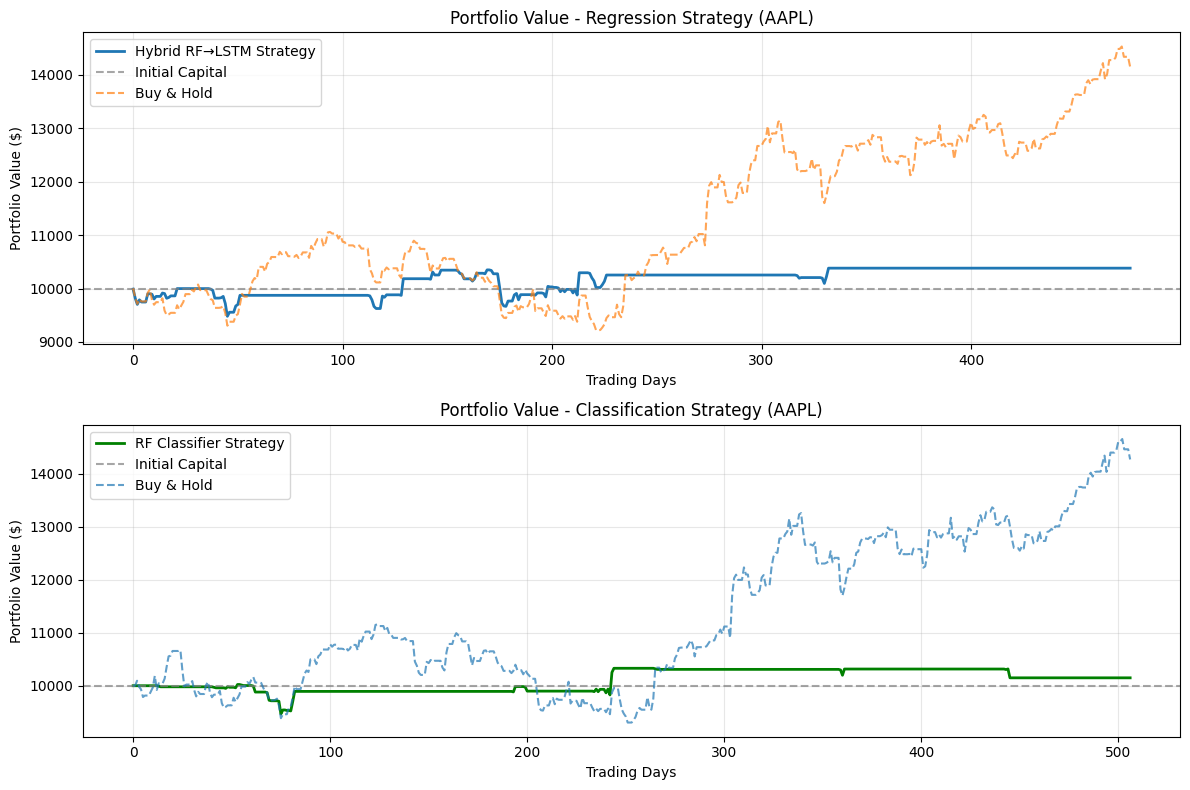


STRATEGY COMPARISON SUMMARY
Metric                         Regression      Classification 
----------------------------------------------------------------------
Total Return (%)                         3.82           1.49
Buy & Hold Return (%)                   41.20          42.45
Excess Return (%)                      -37.38         -40.96
Number of Trades                           34             30
Sharpe Ratio                             0.31           0.18
Max Drawdown (%)                        -6.59          -5.55


In [78]:
# Visualize portfolio growth
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Regression Strategy
axes[0].plot(
    trading_results_regression['Portfolio Values'], 
    label='Hybrid RF→LSTM Strategy',
    linewidth=2
)
axes[0].axhline(
    y=10000, 
    color='gray', 
    linestyle='--', 
    label='Initial Capital',
    alpha=0.7
)
# Buy & Hold line
buy_hold_values = 10000 * (y_true_h / y_true_h[0])
axes[0].plot(
    buy_hold_values, 
    label='Buy & Hold',
    linestyle='--',
    alpha=0.7
)
axes[0].set_title('Portfolio Value - Regression Strategy (AAPL)')
axes[0].set_xlabel('Trading Days')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Classification Strategy
axes[1].plot(
    trading_results_classifier['Portfolio Values'], 
    label='RF Classifier Strategy',
    linewidth=2,
    color='green'
)
axes[1].axhline(
    y=10000, 
    color='gray', 
    linestyle='--', 
    label='Initial Capital',
    alpha=0.7
)
# Buy & Hold line
buy_hold_values_clf = 10000 * (y_test_stock.values / y_test_stock.values[0])
axes[1].plot(
    buy_hold_values_clf, 
    label='Buy & Hold',
    linestyle='--',
    alpha=0.7
)
axes[1].set_title('Portfolio Value - Classification Strategy (AAPL)')
axes[1].set_xlabel('Trading Days')
axes[1].set_ylabel('Portfolio Value ($)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
savefig("trading_simulation_comparison.png")
plt.show()

# Summary comparison
print("\n" + "=" * 70)
print("STRATEGY COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Metric':<30} {'Regression':<15} {'Classification':<15}")
print("-" * 70)
print(f"{'Total Return (%)':<30} {trading_results_regression['Total Return (%)']:>14.2f} {trading_results_classifier['Total Return (%)']:>14.2f}")
print(f"{'Buy & Hold Return (%)':<30} {trading_results_regression['Buy & Hold Return (%)']:>14.2f} {trading_results_classifier['Buy & Hold Return (%)']:>14.2f}")
print(f"{'Excess Return (%)':<30} {trading_results_regression['Excess Return (%)']:>14.2f} {trading_results_classifier['Excess Return (%)']:>14.2f}")
print(f"{'Number of Trades':<30} {trading_results_regression['Number of Trades']:>14} {trading_results_classifier['Number of Trades']:>14}")
print(f"{'Sharpe Ratio':<30} {trading_results_regression['Sharpe Ratio']:>14.2f} {trading_results_classifier['Sharpe Ratio']:>14.2f}")
print(f"{'Max Drawdown (%)':<30} {trading_results_regression['Max Drawdown (%)']:>14.2f} {trading_results_classifier['Max Drawdown (%)']:>14.2f}")
print("=" * 70)

In [79]:
# ==================================
# 9.6 Results comparison table (AAPL)
# ==================================

results_aapl = pd.DataFrame({
    "Model": [
        "Random Forest",
        "XGBoost",
        "LSTM",
        "Hybrid RF→LSTM"
    ],
    "MAE": [
        mae_rf_stock,
        mae_xgb_stock,
        mae_l,
        mae_h
    ],
    "RMSE": [
        rmse_rf_stock,
        rmse_xgb_stock,
        rmse_l,
        rmse_h
    ],
    "MAPE (%)": [
        mape_rf_stock,
        mape_xgb_stock,
        mape_l,
        mape_h
    ],
    "Directional Accuracy (%)": [
        dir_acc_rf_stock * 100,
        dir_acc_xgb_stock * 100,
        dir_acc_l * 100,
        dir_acc_h * 100
    ]
})

results_aapl


,Model,MAE,RMSE,MAPE (%),Directional Accuracy (%)
0,Random Forest,17.087841,25.076303,7.691606,33.596838
1,XGBoost,17.456249,25.926314,7.818810,34.189723
2,LSTM,197.132991,198.224743,99.092303,33.193277
3,Hybrid RF→LSTM,7.610038,9.618339,3.618899,35.924370


## 10. Hybrid RF → LSTM model for cryptocurrency prediction

To assess the generalisability of the proposed hybrid framework, the same methodology is applied to cryptocurrency price prediction using Bitcoin (BTC-USD).

Cryptocurrency markets differ from equity markets in terms of volatility, trading hours and investor behaviour. Therefore, evaluating the hybrid model
on BTC-USD provides an important robustness check.

The modelling pipeline remains unchanged to ensure a fair comparison:
- Random Forest is used for feature selection
- LSTM models temporal dependencies using the selected features
- Performance is evaluated on a chronologically held-out test set


### 10.1 Hybrid RF→LSTM Training for Cryptocurrency

This section visualises the training and validation loss curves of the hybrid Random Forest → LSTM model for BTC-USD. Monitoring these curves helps assess model convergence, stability and potential overfitting during the training process on cryptocurrency price data.


In [80]:
# ==================================
# 10.1 Random Forest baseline (BTC)
# ==================================

rf_crypto = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_crypto.fit(X_train_crypto, y_train_crypto)

y_pred_rf_crypto = rf_crypto.predict(X_test_crypto)

mae_rf_crypto, rmse_rf_crypto, mape_rf_crypto = regression_metrics(y_test_crypto, y_pred_rf_crypto)
dir_acc_rf_crypto = directional_accuracy(y_test_crypto, y_pred_rf_crypto)

print("Random Forest – BTC-USD")
print(f"MAE  : {mae_rf_crypto:.4f}")
print(f"RMSE : {rmse_rf_crypto:.4f}")
print(f"MAPE : {mape_rf_crypto:.2f}%")
print(f"Directional Accuracy: {dir_acc_rf_crypto:.2%}")


Random Forest – BTC-USD
MAE  : 5960.8890
RMSE : 11340.3126
MAPE : 7.95%
Directional Accuracy: 45.26%


### 10.2 Random Forest Baseline Evaluation – BTC-USD

A Random Forest regression model is evaluated as a baseline for cryptocurrency price prediction. The performance metrics obtained here serve as a reference point for assessing the effectiveness of the hybrid modelling approach.


In [82]:
# ==================================
# 10.2 RF feature selection (BTC)
# ==================================

TOP_N = 10

top_features_btc, btc_importance = get_top_features_from_rf(rf_crypto, X_train_crypto.columns, top_n=TOP_N)

print("Top features (BTC-USD):")
for i, f in enumerate(top_features_btc, start=1):
    print(f"{i}. {f}")


Top features (BTC-USD):
1. Close_BTC_SMA_5
2. Close_BTC_EMA_10
3. Close_BTC_SMA_10
4. Close_AAPL_BB_UP
5. Close_BTC_RET
6. Close_BTC_RSI_14
7. Close_BTC_BB_LOW
8. Close_BTC_MACD_HIST
9. Close_BTC_MACD
10. Close_AAPL_MACD_HIST


### 10.3 Feature Importance-Based Feature Selection (BTC-USD)

This section identifies the most influential features for BTC-USD prediction using Random Forest feature importance scores. Selected features include both cryptocurrency-specific indicators and cross-market stock indicators, supporting the hypothesis of inter-market relationships.


In [83]:
# ==================================
# 10.3 Reduce features and scale X & y (BTC)
# ==================================

X_train_btc_top = X_train_crypto[top_features_btc]
X_test_btc_top  = X_test_crypto[top_features_btc]

x_scaler_btc = MinMaxScaler()
y_scaler_btc = MinMaxScaler()

X_train_btc_scaled = x_scaler_btc.fit_transform(X_train_btc_top)
X_test_btc_scaled  = x_scaler_btc.transform(X_test_btc_top)

y_train_btc_scaled = y_scaler_btc.fit_transform(
    y_train_crypto.values.reshape(-1, 1)
)
y_test_btc_scaled = y_scaler_btc.transform(
    y_test_crypto.values.reshape(-1, 1)
)

print("Reduced BTC X_train shape:", X_train_btc_scaled.shape)
print("Reduced BTC X_test shape :", X_test_btc_scaled.shape)


Reduced BTC X_train shape: (2028, 10)
Reduced BTC X_test shape : (507, 10)


### 10.4 Reduced Feature Dataset Construction for BTC-USD

Based on the selected important features, a reduced feature dataset is created for BTC-USD. This dimensionality reduction aims to improve LSTM efficiency and reduce noise while preserving predictive information.


In [84]:
# ==================================
# 10.4 Create sequences for hybrid BTC model
# ==================================

X_train_btc_seq, y_train_btc_seq = create_sequences_xy(
    X_train_btc_scaled, y_train_btc_scaled, LOOKBACK_WINDOW
)

X_test_btc_seq, y_test_btc_seq = create_sequences_xy(
    X_test_btc_scaled, y_test_btc_scaled, LOOKBACK_WINDOW
)

print("BTC train sequences:", X_train_btc_seq.shape, y_train_btc_seq.shape)
print("BTC test sequences :", X_test_btc_seq.shape, y_test_btc_seq.shape)


BTC train sequences: (1998, 30, 10) (1998, 1)
BTC test sequences : (477, 30, 10) (477, 1)


### 10.5 Hybrid RF→LSTM Model Training – Cryptocurrency

The hybrid RF→LSTM model is trained on the reduced BTC-USD feature set using time-series sequences. Learning rate scheduling and validation monitoring are applied to enhance training stability and generalisation performance.


In [85]:
# ==================================
# 10.5 Train hybrid RF → LSTM (BTC)
# ==================================

hybrid_lstm_btc = build_lstm(
    input_shape=(X_train_btc_seq.shape[1], X_train_btc_seq.shape[2])
)

hybrid_lstm_btc.summary()

history_hybrid_btc = hybrid_lstm_btc.fit(
    X_train_btc_seq,
    y_train_btc_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                19200     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19265 (75.25 KB)
Trainable params: 19265 (75.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 4s 33ms/step - loss: 0.0190 - val_loss: 0.0032 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 16ms/step - loss: 0.0057 - val_loss: 0.0022 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 1s 14m

### 10.6 Hybrid RF→LSTM Model Evaluation – BTC-USD

The trained hybrid model is evaluated on unseen BTC-USD test data using multiple error metrics and directional accuracy. The results are compared against baseline models to assess the hybrid model’s effectiveness in handling highly volatile cryptocurrency markets.


In [86]:
# ==================================
# 10.6 Evaluate hybrid BTC model
# ==================================

y_pred_btc_scaled = hybrid_lstm_btc.predict(X_test_btc_seq).flatten()

y_pred_btc = y_scaler_btc.inverse_transform(
    y_pred_btc_scaled.reshape(-1, 1)
).flatten()

y_true_btc = y_scaler_btc.inverse_transform(
    y_test_btc_seq.reshape(-1, 1)
).flatten()

mae_h_btc, rmse_h_btc, mape_h_btc = regression_metrics(
    pd.Series(y_true_btc), y_pred_btc
)
dir_acc_h_btc = directional_accuracy(
    pd.Series(y_true_btc), y_pred_btc
)

print("Hybrid RF → LSTM – BTC-USD")
print(f"MAE  : {mae_h_btc:.4f}")
print(f"RMSE : {rmse_h_btc:.4f}")
print(f"MAPE : {mape_h_btc:.2f}%")
print(f"Directional Accuracy: {dir_acc_h_btc:.2%}")


15/15 [==============================] - 1s 7ms/step
Hybrid RF → LSTM – BTC-USD
MAE  : 5432.7481
RMSE : 7309.1906
MAPE : 7.99%
Directional Accuracy: 47.27%


### 10.7 Training and Validation Loss Visualisation – BTC-USD

This section visualises the training and validation loss curves of the hybrid RF→LSTM model for BTC-USD. The plot provides insight into the model’s learning behaviour, convergence stability and generalisation performance when applied to highly volatile cryptocurrency price data.


[Saved figure] figures\training_loss_btc.png


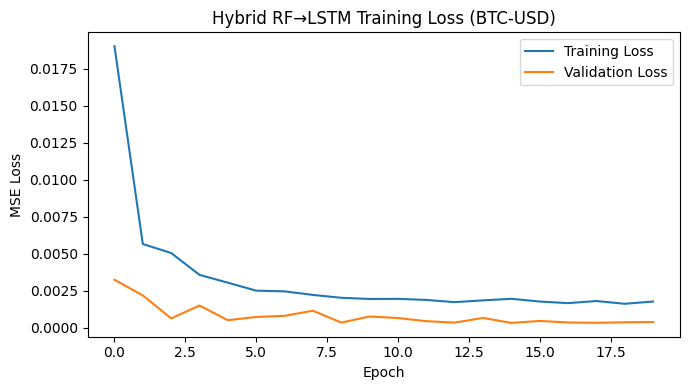

In [87]:
# ==================================
# 10.7 Hybrid BTC training loss
# ==================================

plt.figure(figsize=(7, 4))
plt.plot(history_hybrid_btc.history["loss"], label="Training Loss")
plt.plot(history_hybrid_btc.history["val_loss"], label="Validation Loss")
plt.title("Hybrid RF→LSTM Training Loss (BTC-USD)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
savefig("training_loss_btc.png")
plt.show()


## 11. Cross-asset performance comparison

This section compares the predictive performance of all models across two distinct financial markets: equities (AAPL) and cryptocurrencies (BTC-USD).

This section extends the cross-asset results tables by including classical regression baselines and baseline models.These models provide a lower-bound benchmark and strengthen the evaluation framework for hybrid modelling methodology.

By analysing error metrics and directional accuracy across asset classes, this comparison evaluates the robustness, generalisability and limitations
of the proposed hybrid RF→LSTM framework.

Such cross-market evaluation is essential for understanding how marketstructure, volatility and trading behaviour influence predictive performance.


### 11.1 Cross-Asset Performance Comparison

Model performance is compared across stock and cryptocurrency markets to analyse differences in predictive behaviour and robustness.



In [88]:
# ==================================
# AAPL model table
# ==================================

results_aapl_expanded = pd.DataFrame({
    "Asset": ["AAPL"] * 7,
    "Model": [
        "Linear Regression",
        "Ridge Regression",
        "SVR (RBF)",
        "Random Forest",
        "XGBoost",
        "LSTM",
        "Hybrid RF→LSTM"
    ],
    "MAE": [
        mae_lr_stock,
        mae_ridge_stock,
        mae_svr_stock,
        mae_rf_stock,
        mae_xgb_stock,
        mae_l,
        mae_h
    ],
    "RMSE": [
        rmse_lr_stock,
        rmse_ridge_stock,
        rmse_svr_stock,
        rmse_rf_stock,
        rmse_xgb_stock,
        rmse_l,
        rmse_h
    ],
    "MAPE (%)": [
        mape_lr_stock,
        mape_ridge_stock,
        mape_svr_stock,
        mape_rf_stock,
        mape_xgb_stock,
        mape_l,
        mape_h
    ],
    "Directional Accuracy (%)": [
        dir_acc_lr_stock * 100,
        dir_acc_ridge_stock * 100,
        dir_acc_svr_stock * 100,
        dir_acc_rf_stock * 100,
        dir_acc_xgb_stock * 100,
        dir_acc_l * 100,
        dir_acc_h * 100
    ]
})

results_aapl_expanded

# ==================================
# BTC-USD model table
# ==================================

results_btc_minimal = pd.DataFrame({
    "Asset": ["BTC-USD", "BTC-USD"],
    "Model": ["Random Forest", "Hybrid RF→LSTM"],
    "MAE": [mae_rf_crypto, mae_h_btc],
    "RMSE": [rmse_rf_crypto, rmse_h_btc],
    "MAPE (%)": [mape_rf_crypto, mape_h_btc],
    "Directional Accuracy (%)": [dir_acc_rf_crypto * 100, dir_acc_h_btc * 100]
})

# ==================================
# Combined model table
# ==================================
results_combined_expanded = pd.concat(
    [results_aapl_expanded, results_btc_minimal],
    ignore_index=True
)

results_combined_expanded


,Asset,Model,MAE,RMSE,MAPE (%),Directional Accuracy (%)
0,AAPL,Linear Regression,1.645565,2.412848,0.833063,33.596838
1,AAPL,Ridge Regression,1.850667,2.569836,0.940985,35.177866
2,AAPL,SVR (RBF),42.088686,56.650874,19.549360,32.015810
3,AAPL,Random Forest,17.087841,25.076303,7.691606,33.596838
4,AAPL,XGBoost,17.456249,25.926314,7.818810,34.189723
5,AAPL,LSTM,197.132991,198.224743,99.092303,33.193277
6,AAPL,Hybrid RF→LSTM,7.610038,9.618339,3.618899,35.924370
7,BTC-USD,Random Forest,5960.889043,11340.312595,7.952549,45.256917
8,BTC-USD,Hybrid RF→LSTM,5432.748063,7309.190616,7.992298,47.268908


In [89]:
# ==================================
# 11.1 Comprehensive Model Comparison 
# ==================================

# Create comprehensive results table
results_comprehensive = pd.DataFrame({
    "Asset": ["AAPL"] * 9 + ["BTC-USD"] * 2,
    "Model": [
        "Linear Regression",
        "Ridge Regression",
        "SVR (RBF)",
        "Random Forest (Reg)",
        "XGBoost (Reg)",
        "LSTM (Reg)",
        "Hybrid RF→LSTM (Reg)",
        "Random Forest (Clf)",
        "LSTM (Clf)",
        "Random Forest (Reg)",
        "Hybrid RF→LSTM (Reg)"
    ],
    "Task": [
        "Regression", "Regression", "Regression", "Regression", "Regression",
        "Regression", "Regression", "Classification", "Classification",
        "Regression", "Regression"
    ],
    "MAE": [
        mae_lr_stock, mae_ridge_stock, mae_svr_stock,
        mae_rf_stock, mae_xgb_stock, mae_l, mae_h,
        np.nan, np.nan,  # Classification doesn't have MAE
        mae_rf_crypto, mae_h_btc
    ],
    "RMSE": [
        rmse_lr_stock, rmse_ridge_stock, rmse_svr_stock,
        rmse_rf_stock, rmse_xgb_stock, rmse_l, rmse_h,
        np.nan, np.nan,  # Classification doesn't have RMSE
        rmse_rf_crypto, rmse_h_btc
    ],
    "MAPE (%)": [
        mape_lr_stock, mape_ridge_stock, mape_svr_stock,
        mape_rf_stock, mape_xgb_stock, mape_l, mape_h,
        np.nan, np.nan,  # Classification doesn't have MAPE
        mape_rf_crypto, mape_h_btc
    ],
    "Accuracy/Dir_Acc (%)": [
        dir_acc_lr_stock * 100,
        dir_acc_ridge_stock * 100,
        dir_acc_svr_stock * 100,
        dir_acc_rf_stock * 100,
        dir_acc_xgb_stock * 100,
        dir_acc_l * 100,
        dir_acc_h * 100,
        acc_rf_stock * 100,  # Classification accuracy
        acc_lstm_clf * 100,  # Classification accuracy
        dir_acc_rf_crypto * 100,
        dir_acc_h_btc * 100
    ],
    "F1-Score": [
        np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
        f1_rf_stock,  # Classification F1
        f1_lstm_clf,  # Classification F1
        np.nan, np.nan
    ],
    "ROC AUC": [
        np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
        auc_rf_stock,  # Classification AUC
        auc_lstm_clf,  # Classification AUC
        np.nan, np.nan
    ]
})



In [91]:
# Format the table for display
results_display = results_comprehensive.copy()

# Format numeric columns
results_display["MAE"] = results_display["MAE"].apply(
    lambda x: f"{x:.4f}" if pd.notna(x) else "-"
)
results_display["RMSE"] = results_display["RMSE"].apply(
    lambda x: f"{x:.4f}" if pd.notna(x) else "-"
)
results_display["MAPE (%)"] = results_display["MAPE (%)"].apply(
    lambda x: f"{x:.2f}" if pd.notna(x) else "-"
)
results_display["Accuracy/Dir_Acc (%)"] = results_display["Accuracy/Dir_Acc (%)"].apply(
    lambda x: f"{x:.2f}" if pd.notna(x) else "-"
)
results_display["F1-Score"] = results_display["F1-Score"].apply(
    lambda x: f"{x:.4f}" if pd.notna(x) else "-"
)
results_display["ROC AUC"] = results_display["ROC AUC"].apply(
    lambda x: f"{x:.4f}" if pd.notna(x) else "-"
)

print("=" * 120)
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print("=" * 120)
display(results_display)

# Highlight best performers
print("\n" + "=" * 120)
print("BEST PERFORMERS BY METRIC")
print("=" * 120)

# Regression metrics (AAPL only)
reg_mask = (results_comprehensive["Asset"] == "AAPL") & (results_comprehensive["Task"] == "Regression")
reg_results = results_comprehensive[reg_mask]

best_mae = reg_results.loc[reg_results["MAE"].idxmin()]
best_rmse = reg_results.loc[reg_results["RMSE"].idxmin()]
best_mape = reg_results.loc[reg_results["MAPE (%)"].idxmin()]

print("\nRegression Task (AAPL):")
print(f"  Best MAE:  {best_mae['Model']:<25} ({best_mae['MAE']:.4f})")
print(f"  Best RMSE: {best_rmse['Model']:<25} ({best_rmse['RMSE']:.4f})")
print(f"  Best MAPE: {best_mape['Model']:<25} ({best_mape['MAPE (%)']:.2f}%)")

# Classification metrics (AAPL only)
clf_mask = (results_comprehensive["Asset"] == "AAPL") & (results_comprehensive["Task"] == "Classification")
clf_results = results_comprehensive[clf_mask]

best_acc = clf_results.loc[clf_results["Accuracy/Dir_Acc (%)"].idxmax()]
best_f1 = clf_results.loc[clf_results["F1-Score"].idxmax()]
best_auc = clf_results.loc[clf_results["ROC AUC"].idxmax()]

print("\nClassification Task (AAPL):")
print(f"  Best Accuracy: {best_acc['Model']:<25} ({best_acc['Accuracy/Dir_Acc (%)']:.2f}%)")
print(f"  Best F1-Score: {best_f1['Model']:<25} ({best_f1['F1-Score']:.4f})")
print(f"  Best ROC AUC:  {best_auc['Model']:<25} ({best_auc['ROC AUC']:.4f})")

print("=" * 120)


COMPREHENSIVE MODEL COMPARISON TABLE


,Asset,Model,Task,MAE,RMSE,MAPE (%),Accuracy/Dir_Acc (%),F1-Score,ROC AUC
0,AAPL,Linear Regression,Regression,1.6456,2.4128,0.83,33.60,-,-
1,AAPL,Ridge Regression,Regression,1.8507,2.5698,0.94,35.18,-,-
2,AAPL,SVR (RBF),Regression,42.0887,56.6509,19.55,32.02,-,-
3,AAPL,Random Forest (Reg),Regression,17.0878,25.0763,7.69,33.60,-,-
4,AAPL,XGBoost (Reg),Regression,17.4562,25.9263,7.82,34.19,-,-
5,AAPL,LSTM (Reg),Regression,197.1330,198.2247,99.09,33.19,-,-
6,AAPL,Hybrid RF→LSTM (Reg),Regression,7.6100,9.6183,3.62,35.92,-,-
7,AAPL,Random Forest (Clf),Classification,-,-,-,61.74,0.1565,0.5152
8,AAPL,LSTM (Clf),Classification,-,-,-,61.22,0.0000,0.4869
9,BTC-USD,Random Forest (Reg),Regression,5960.8890,11340.3126,7.95,45.26,-,-



BEST PERFORMERS BY METRIC

Regression Task (AAPL):
  Best MAE:  Linear Regression         (1.6456)
  Best RMSE: Linear Regression         (2.4128)
  Best MAPE: Linear Regression         (0.83%)

Classification Task (AAPL):
  Best Accuracy: Random Forest (Clf)       (61.74%)
  Best F1-Score: Random Forest (Clf)       (0.1565)
  Best ROC AUC:  Random Forest (Clf)       (0.5152)


[Saved figure] figures\comprehensive_model_comparison.png


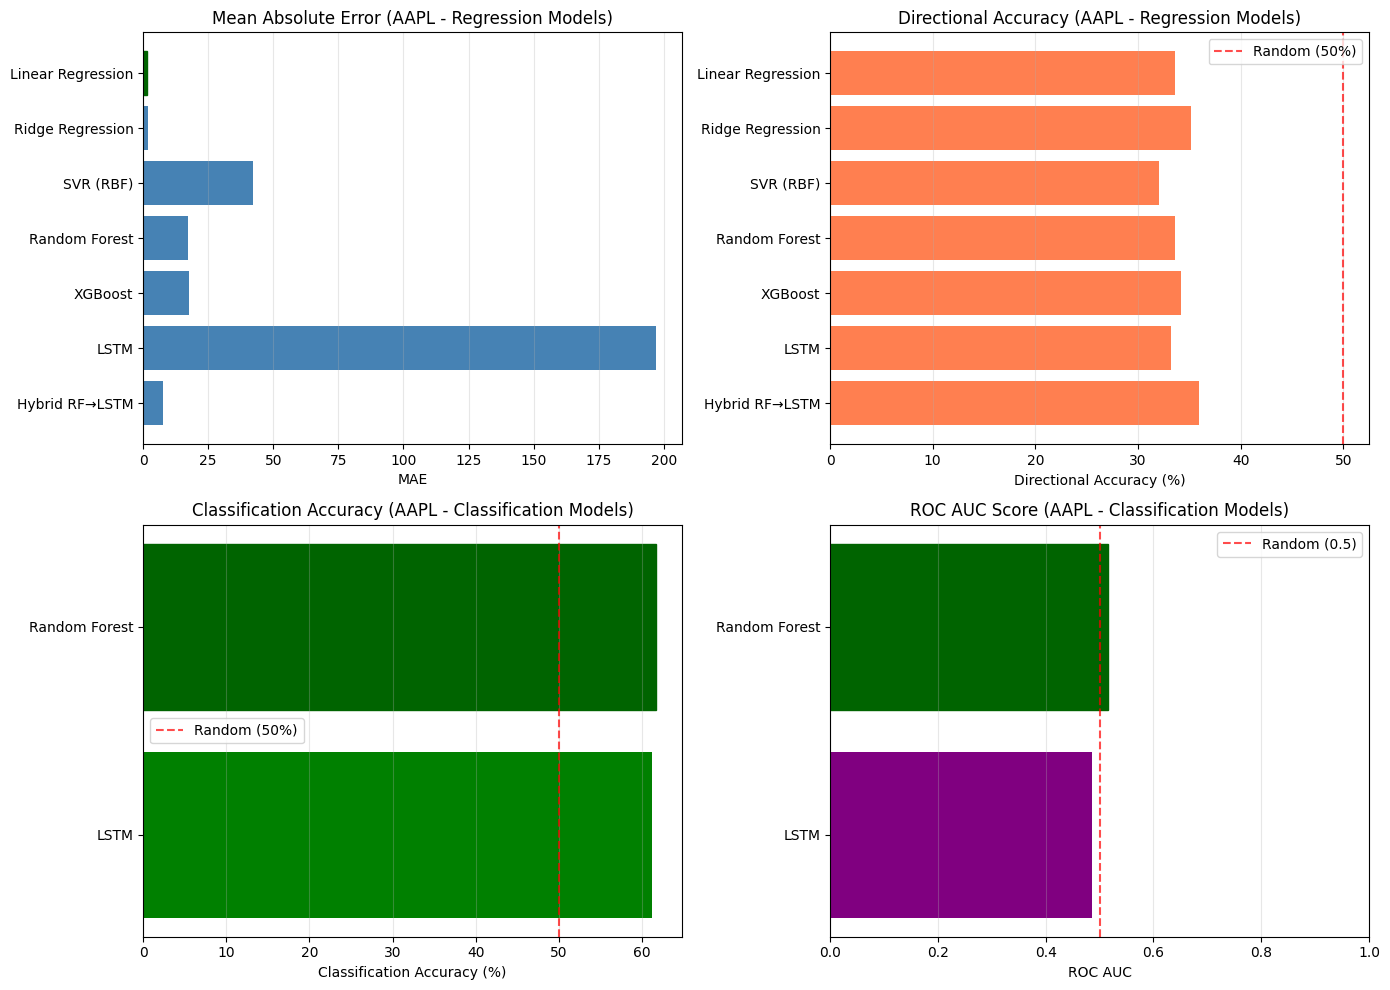

In [92]:
# Create visualization comparing regression vs classification
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAE Comparison (Regression only)
reg_models = reg_results["Model"].str.replace(" (Reg)", "", regex=False)
mae_values = reg_results["MAE"].values
axes[0, 0].barh(reg_models, mae_values, color='steelblue')
axes[0, 0].set_xlabel('MAE')
axes[0, 0].set_title('Mean Absolute Error (AAPL - Regression Models)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Highlight best
best_idx = np.argmin(mae_values)
axes[0, 0].get_children()[best_idx].set_color('darkgreen')

# Plot 2: Directional Accuracy (Regression)
dir_acc_values = reg_results["Accuracy/Dir_Acc (%)"].values
axes[0, 1].barh(reg_models, dir_acc_values, color='coral')
axes[0, 1].axvline(x=50, color='red', linestyle='--', label='Random (50%)', alpha=0.7)
axes[0, 1].set_xlabel('Directional Accuracy (%)')
axes[0, 1].set_title('Directional Accuracy (AAPL - Regression Models)')
axes[0, 1].invert_yaxis()
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Classification Accuracy
clf_models = clf_results["Model"].str.replace(" (Clf)", "", regex=False)
clf_acc_values = clf_results["Accuracy/Dir_Acc (%)"].values
axes[1, 0].barh(clf_models, clf_acc_values, color='green')
axes[1, 0].axvline(x=50, color='red', linestyle='--', label='Random (50%)', alpha=0.7)
axes[1, 0].set_xlabel('Classification Accuracy (%)')
axes[1, 0].set_title('Classification Accuracy (AAPL - Classification Models)')
axes[1, 0].invert_yaxis()
axes[1, 0].legend()
axes[1, 0].grid(axis='x', alpha=0.3)

# Highlight best
best_clf_idx = np.argmax(clf_acc_values)
axes[1, 0].get_children()[best_clf_idx].set_color('darkgreen')

# Plot 4: ROC AUC Comparison
auc_values = clf_results["ROC AUC"].values
axes[1, 1].barh(clf_models, auc_values, color='purple')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', label='Random (0.5)', alpha=0.7)
axes[1, 1].set_xlabel('ROC AUC')
axes[1, 1].set_title('ROC AUC Score (AAPL - Classification Models)')
axes[1, 1].set_xlim([0, 1])
axes[1, 1].invert_yaxis()
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

# Highlight best
best_auc_idx = np.argmax(auc_values)
axes[1, 1].get_children()[best_auc_idx].set_color('darkgreen')

plt.tight_layout()
savefig("comprehensive_model_comparison.png")
plt.show()

### 11.2 Relative Improvement Analysis

This section quantifies the relative improvement of the hybrid model over baseline approaches using percentage-based metrics.


In [93]:
# ==================================
# 11.2 Relative improvement (%) vs Random Forest
# ==================================

improvement = pd.DataFrame({
    "Asset": ["AAPL", "BTC-USD"],
    "MAE Improvement (%)": [
        (1 - mae_h / mae_rf_stock) * 100,
        (1 - mae_h_btc / mae_rf_crypto) * 100
    ],
    "RMSE Improvement (%)": [
        (1 - rmse_h / rmse_rf_stock) * 100,
        (1 - rmse_h_btc / rmse_rf_crypto) * 100
    ]
})

improvement


,Asset,MAE Improvement (%),RMSE Improvement (%)
0,AAPL,55.465186,61.643713
1,BTC-USD,8.860104,35.546833


### 11.3 Visual Comparison of Hybrid Model Gains

A bar chart visualises the performance gains achieved by the hybrid model across different asset classes.


[Saved figure] figures\hybrid_improvement_rf.png


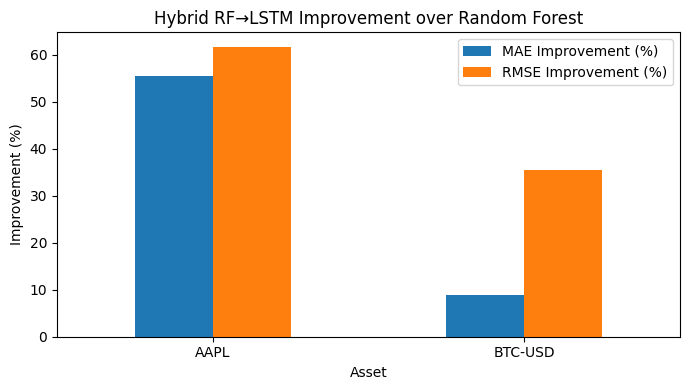

In [94]:
# ==================================
# 11.3 Visual comparison of hybrid gains
# ==================================

improvement.set_index("Asset").plot(
    kind="bar",
    figsize=(7, 4)
)

plt.title("Hybrid RF→LSTM Improvement over Random Forest")
plt.ylabel("Improvement (%)")
plt.xticks(rotation=0)
plt.tight_layout()
savefig("hybrid_improvement_rf.png")
plt.show()


## 11.4 Robust evaluation additions (naïve baseline & walk-forward validation)

To strengthen the validity of the findings for a time-series forecasting task, this section adds two widely used evaluation components:

- **Naïve (persistence) baseline:** tomorrow's close is assumed to be today's close. This is a strong baseline in financial time series and helps contextualise model performance.
- **Walk-forward (TimeSeriesSplit) validation:** classical ML models are evaluated over multiple chronological folds to reduce dependence on a single train/test split.

> Note: Deep learning models (LSTM / Hybrid) can be computationally expensive to re-train across many folds. Therefore, walk-forward validation is applied to the classical ML baselines, while LSTM/Hybrid results are reported on the fixed holdout split used throughout the notebook.


In [95]:
# ==================================
# 11.4.1 Utility: unified metrics + naïve baseline
# ==================================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from sklearn.pipeline import Pipeline

def regression_metrics_dict(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # avoid division by zero in MAPE
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    dir_acc = directional_accuracy(pd.Series(y_true), pd.Series(y_pred))
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape,
        "Directional_Acc": dir_acc
    }

def naive_persistence_forecast(y_train, y_test):
    """Predicts y[t] as y[t-1]. For the first test point, uses last train value."""
    y_train = pd.Series(y_train).reset_index(drop=True)
    y_test = pd.Series(y_test).reset_index(drop=True)
    y_pred = y_test.shift(1)
    y_pred.iloc[0] = y_train.iloc[-1]
    return y_pred.values

# Naïve baseline (AAPL)
y_pred_naive_stock = naive_persistence_forecast(y_train_stock, y_test_stock)
naive_stock_metrics = regression_metrics_dict(y_test_stock, y_pred_naive_stock)

print("Naïve (Persistence) Baseline – AAPL")
for k,v in naive_stock_metrics.items():
    if k == "Directional_Acc":
        print(f"{k}: {v:.2%}")
    elif k == "MAPE_%":
        print(f"{k}: {v:.2f}%")
    else:
        print(f"{k}: {v:.4f}")

# Naïve baseline (BTC)
y_pred_naive_crypto = naive_persistence_forecast(y_train_crypto, y_test_crypto)
naive_crypto_metrics = regression_metrics_dict(y_test_crypto, y_pred_naive_crypto)

print("\nNaïve (Persistence) Baseline – BTC-USD")
for k,v in naive_crypto_metrics.items():
    if k == "Directional_Acc":
        print(f"{k}: {v:.2%}")
    elif k == "MAPE_%":
        print(f"{k}: {v:.2f}%")
    else:
        print(f"{k}: {v:.4f}")


Naïve (Persistence) Baseline – AAPL
MAE: 1.3733
RMSE: 2.2355
MAPE_%: 0.69%
Directional_Acc: 43.08%

Naïve (Persistence) Baseline – BTC-USD
MAE: 1096.7296
RMSE: 1629.3337
MAPE_%: 1.85%
Directional_Acc: 47.63%


In [96]:
# ==================================
# 11.4.2 Walk-forward validation for classical ML baselines
# ==================================
# This evaluates each model over multiple chronological folds.
# It is especially useful for financial time series where regime changes occur.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
import warnings

tscv = TimeSeriesSplit(n_splits=5)

def walk_forward_cv(model, X_df, y_series, name="model"):
    fold_rows = []
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_df), start=1):
        X_tr, X_te = X_df.iloc[train_idx], X_df.iloc[test_idx]
        y_tr, y_te = y_series.iloc[train_idx], y_series.iloc[test_idx]

        m = clone(model)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=LinAlgWarning)
            m.fit(X_tr, y_tr)

        y_pred = m.predict(X_te)
        metrics = regression_metrics_dict(y_te, y_pred)
        metrics["Fold"] = fold
        fold_rows.append(metrics)

    df = pd.DataFrame(fold_rows)
    summary = df.drop(columns=["Fold"]).mean(numeric_only=True).to_dict()
    print(f"{name} walk-forward CV (mean over {tscv.get_n_splits()} folds)")
    for k, v in summary.items():
        if k == "Directional_Acc":
            print(f"  {k}: {v:.2%}")
        elif k == "MAPE_%":
            print(f"  {k}: {v:.2f}%")
        else:
            print(f"  {k}: {v:.4f}")
    return df, summary


# Define baseline models for CV
baseline_models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=10.0))  # slightly stronger regularisation improves stability
    ]),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=SEED, n_jobs=-1, max_depth=None, min_samples_leaf=1
    ),
    "SVR(RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf", C=50, gamma="scale", epsilon=0.1))
    ])
}

if XGB_AVAILABLE:
    baseline_models["XGBoost"] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        random_state=SEED, n_jobs=-1
    )

# Run walk-forward CV for AAPL and BTC
cv_results = {}

print("\n--- Walk-forward CV: AAPL ---")
for name, model in baseline_models.items():
    df_folds, summary = walk_forward_cv(model, X, y_stock, name)
    cv_results[("AAPL", name)] = summary

print("\n--- Walk-forward CV: BTC-USD ---")
for name, model in baseline_models.items():
    df_folds, summary = walk_forward_cv(model, X, y_crypto, name)
    cv_results[("BTC", name)] = summary



--- Walk-forward CV: AAPL ---
LinearRegression walk-forward CV (mean over 5 folds)
  MAE: 1.5076
  RMSE: 2.1729
  MAPE_%: 1.16%
  Directional_Acc: 34.35%
Ridge walk-forward CV (mean over 5 folds)
  MAE: 1.7090
  RMSE: 2.3661
  MAPE_%: 1.31%
  Directional_Acc: 33.73%
RandomForest walk-forward CV (mean over 5 folds)
  MAE: 18.2218
  RMSE: 22.2118
  MAPE_%: 13.62%
  Directional_Acc: 34.73%
SVR(RBF) walk-forward CV (mean over 5 folds)
  MAE: 32.5719
  RMSE: 38.1005
  MAPE_%: 24.01%
  Directional_Acc: 34.54%
XGBoost walk-forward CV (mean over 5 folds)
  MAE: 18.9421
  RMSE: 23.0166
  MAPE_%: 14.21%
  Directional_Acc: 33.21%

--- Walk-forward CV: BTC-USD ---
LinearRegression walk-forward CV (mean over 5 folds)
  MAE: 840.9555
  RMSE: 1217.6764
  MAPE_%: 2.74%
  Directional_Acc: 49.36%
Ridge walk-forward CV (mean over 5 folds)
  MAE: 971.5910
  RMSE: 1371.3735
  MAPE_%: 3.17%
  Directional_Acc: 47.32%
RandomForest walk-forward CV (mean over 5 folds)
  MAE: 6204.8729
  RMSE: 9083.5022
  MAPE_

### 11.4.3 Compact summary table (naïve baseline + walk-forward CV)

The table below combines:
- the **naïve baseline** performance on the holdout split, and
- the **walk-forward CV mean** scores for classical ML models.

Use this table in Chapter 4 (Results) to support stronger, more defensible comparisons.


In [98]:
# Build summary table
rows = []

# Naïve baselines
rows.append({"Asset": "AAPL", "Model": "Naïve (Persistence)", **naive_stock_metrics})
rows.append({"Asset": "BTC", "Model": "Naïve (Persistence)", **naive_crypto_metrics})

# CV means
for (asset, name), summary in cv_results.items():
    rows.append({"Asset": asset, "Model": f"{name} (CV mean)", **summary})

summary_df = pd.DataFrame(rows)
summary_df["Directional_Acc"] = summary_df["Directional_Acc"].apply(lambda x: f"{x:.2%}")
summary_df["MAE"] = summary_df["MAE"].map(lambda x: f"{x:.4f}")
summary_df["RMSE"] = summary_df["RMSE"].map(lambda x: f"{x:.4f}")
summary_df["MAPE_%"] = summary_df["MAPE_%"].map(lambda x: f"{x:.2f}%")

display(summary_df)


,Asset,Model,MAE,RMSE,MAPE_%,Directional_Acc
0,AAPL,Naïve (Persistence),1.3733,2.2355,0.69%,43.08%
1,BTC,Naïve (Persistence),1096.7296,1629.3337,1.85%,47.63%
2,AAPL,LinearRegression (CV mean),1.5076,2.1729,1.16%,34.35%
3,AAPL,Ridge (CV mean),1.7090,2.3661,1.31%,33.73%
4,AAPL,RandomForest (CV mean),18.2218,22.2118,13.62%,34.73%
5,AAPL,SVR(RBF) (CV mean),32.5719,38.1005,24.01%,34.54%
6,AAPL,XGBoost (CV mean),18.9421,23.0166,14.21%,33.21%
7,BTC,LinearRegression (CV mean),840.9555,1217.6764,2.74%,49.36%
8,BTC,Ridge (CV mean),971.5910,1371.3735,3.17%,47.32%
9,BTC,RandomForest (CV mean),6204.8729,9083.5022,15.77%,49.17%


In [99]:
# ==================================
# 11.5 Market Regime Analysis (NEW)
# ==================================

print("=" * 70)
print("MARKET REGIME ANALYSIS")
print("=" * 70)

def analyze_by_market_regime(y_true, y_pred, prices, window=20):
    """
    Evaluates model performance in different market conditions.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    prices : array-like
        Actual prices for regime detection
    window : int
        Window for calculating trend
    
    Returns:
    --------
    dict : Performance metrics by regime
    """
    # Calculate price momentum
    returns = pd.Series(prices).pct_change()
    momentum = returns.rolling(window).mean()
    
    # Define regimes
    bull_mask = (momentum > 0.001).values  # Uptrend
    bear_mask = (momentum < -0.001).values  # Downtrend
    sideways_mask = (~bull_mask & ~bear_mask)  # Sideways
    
    # Remove NaN from rolling calculation
    valid_idx = ~momentum.isna()
    
    def calc_metrics(mask):
        mask_valid = mask & valid_idx
        if mask_valid.sum() < 5:  # Need at least 5 samples
            return None
        
        y_t = y_true[mask_valid]
        y_p = y_pred[mask_valid]
        
        mae = mean_absolute_error(y_t, y_p)
        rmse = np.sqrt(mean_squared_error(y_t, y_p))
        mape = np.mean(np.abs((y_t - y_p) / (y_t + 1e-9))) * 100
        dir_acc = directional_accuracy(pd.Series(y_t), pd.Series(y_p))
        
        return {
            'Count': mask_valid.sum(),
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'Dir_Acc (%)': dir_acc * 100
        }
    
    bull_metrics = calc_metrics(bull_mask)
    bear_metrics = calc_metrics(bear_mask)
    sideways_metrics = calc_metrics(sideways_mask)
    
    return {
        'Bull Market': bull_metrics,
        'Bear Market': bear_metrics,
        'Sideways Market': sideways_metrics,
        'Bull %': (bull_mask & valid_idx).sum() / valid_idx.sum() * 100,
        'Bear %': (bear_mask & valid_idx).sum() / valid_idx.sum() * 100,
        'Sideways %': (sideways_mask & valid_idx).sum() / valid_idx.sum() * 100
    }

# Analyze Hybrid RF→LSTM (Regression)
print("\n" + "=" * 70)
print("HYBRID RF→LSTM - MARKET REGIME ANALYSIS (AAPL)")
print("=" * 70)

regime_results = analyze_by_market_regime(
    y_true=y_true_h,
    y_pred=y_pred_h,
    prices=y_true_h,
    window=20
)

print(f"\nMarket Distribution:")
print(f"  Bull Market:     {regime_results['Bull %']:.1f}%")
print(f"  Bear Market:     {regime_results['Bear %']:.1f}%")
print(f"  Sideways Market: {regime_results['Sideways %']:.1f}%")

regime_df = pd.DataFrame({
    'Regime': ['Bull Market', 'Bear Market', 'Sideways Market'],
    'Sample Count': [
        regime_results['Bull Market']['Count'],
        regime_results['Bear Market']['Count'],
        regime_results['Sideways Market']['Count']
    ],
    'MAE': [
        regime_results['Bull Market']['MAE'],
        regime_results['Bear Market']['MAE'],
        regime_results['Sideways Market']['MAE']
    ],
    'RMSE': [
        regime_results['Bull Market']['RMSE'],
        regime_results['Bear Market']['RMSE'],
        regime_results['Sideways Market']['RMSE']
    ],
    'MAPE (%)': [
        regime_results['Bull Market']['MAPE (%)'],
        regime_results['Bear Market']['MAPE (%)'],
        regime_results['Sideways Market']['MAPE (%)']
    ],
    'Dir_Acc (%)': [
        regime_results['Bull Market']['Dir_Acc (%)'],
        regime_results['Bear Market']['Dir_Acc (%)'],
        regime_results['Sideways Market']['Dir_Acc (%)']
    ]
})

print("\nPerformance by Market Regime:")
display(regime_df)


MARKET REGIME ANALYSIS

HYBRID RF→LSTM - MARKET REGIME ANALYSIS (AAPL)

Market Distribution:
  Bull Market:     49.0%
  Bear Market:     25.4%
  Sideways Market: 25.6%

Performance by Market Regime:


,Regime,Sample Count,MAE,RMSE,MAPE (%),Dir_Acc (%)
0,Bull Market,224,11.531925,12.809796,5.335927,41.704036
1,Bear Market,116,3.631774,4.653703,1.887760,37.391304
2,Sideways Market,117,4.802479,6.260793,2.350907,35.344828


[Saved figure] figures\market_regime_analysis.png


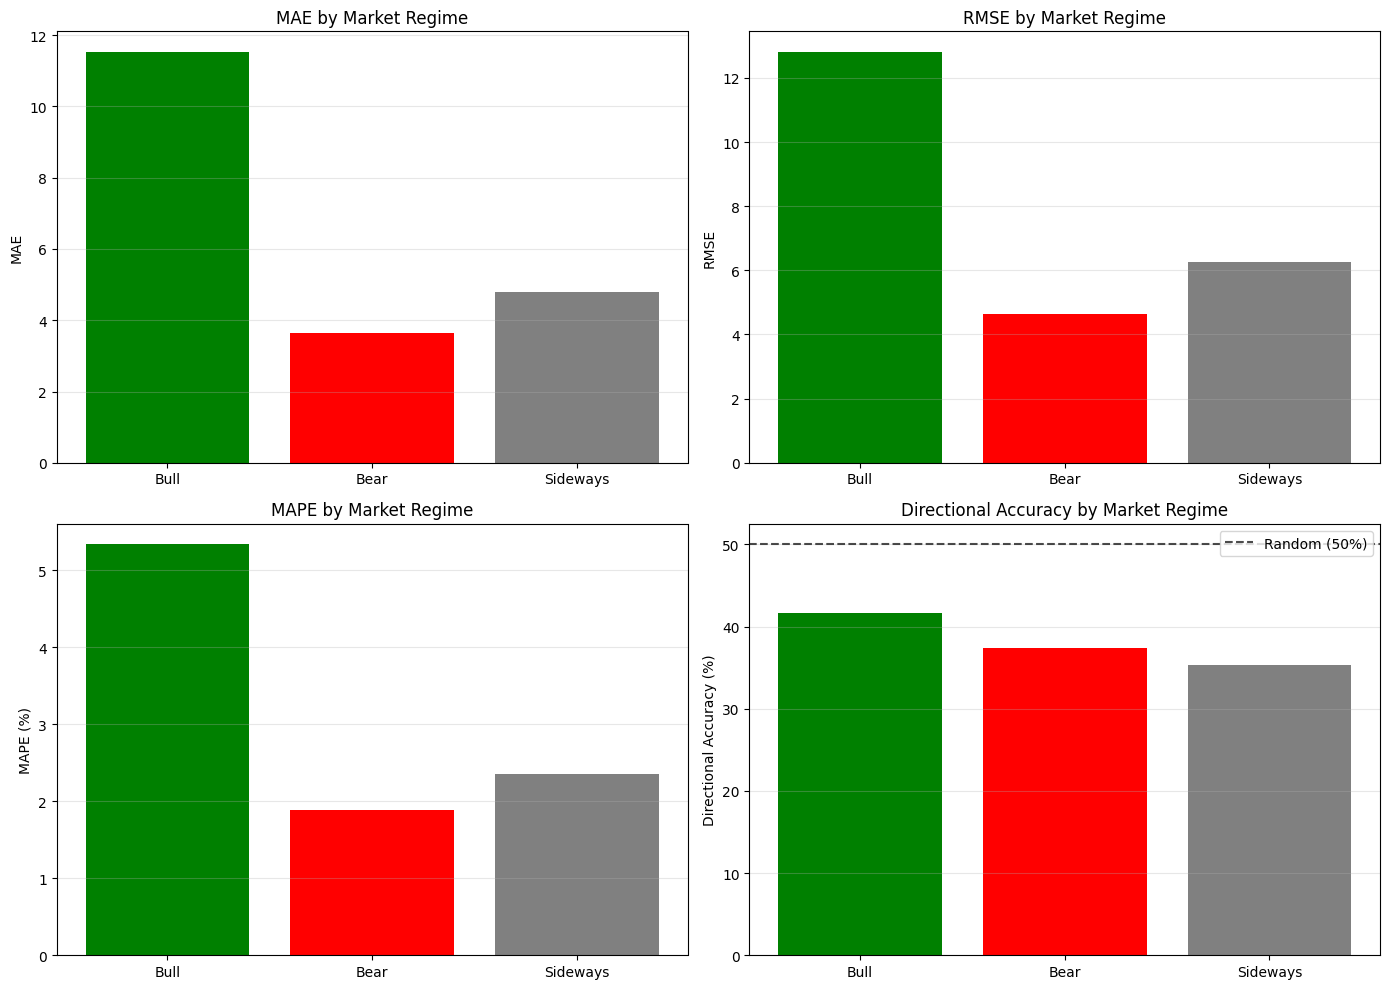


KEY INSIGHTS
✓ Best MAE performance:        Bear Market (3.6318)
✗ Worst MAE performance:       Bull Market (11.5319)
✓ Best directional accuracy:   Bull Market (41.70%)
  Model performs 3.18x worse in Bull markets


In [100]:
# Visualize regime performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAE by Regime
regimes = ['Bull', 'Bear', 'Sideways']
mae_by_regime = [
    regime_results['Bull Market']['MAE'],
    regime_results['Bear Market']['MAE'],
    regime_results['Sideways Market']['MAE']
]
axes[0, 0].bar(regimes, mae_by_regime, color=['green', 'red', 'gray'])
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_title('MAE by Market Regime')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: RMSE by Regime
rmse_by_regime = [
    regime_results['Bull Market']['RMSE'],
    regime_results['Bear Market']['RMSE'],
    regime_results['Sideways Market']['RMSE']
]
axes[0, 1].bar(regimes, rmse_by_regime, color=['green', 'red', 'gray'])
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE by Market Regime')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: MAPE by Regime
mape_by_regime = [
    regime_results['Bull Market']['MAPE (%)'],
    regime_results['Bear Market']['MAPE (%)'],
    regime_results['Sideways Market']['MAPE (%)']
]
axes[1, 0].bar(regimes, mape_by_regime, color=['green', 'red', 'gray'])
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].set_title('MAPE by Market Regime')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Directional Accuracy by Regime
dir_acc_by_regime = [
    regime_results['Bull Market']['Dir_Acc (%)'],
    regime_results['Bear Market']['Dir_Acc (%)'],
    regime_results['Sideways Market']['Dir_Acc (%)']
]
axes[1, 1].bar(regimes, dir_acc_by_regime, color=['green', 'red', 'gray'])
axes[1, 1].axhline(y=50, color='black', linestyle='--', label='Random (50%)', alpha=0.7)
axes[1, 1].set_ylabel('Directional Accuracy (%)')
axes[1, 1].set_title('Directional Accuracy by Market Regime')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
savefig("market_regime_analysis.png")
plt.show()

# Key insights
print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)

best_regime_mae = regimes[np.argmin(mae_by_regime)]
worst_regime_mae = regimes[np.argmax(mae_by_regime)]
best_regime_dir = regimes[np.argmax(dir_acc_by_regime)]

print(f"✓ Best MAE performance:        {best_regime_mae} Market ({min(mae_by_regime):.4f})")
print(f"✗ Worst MAE performance:       {worst_regime_mae} Market ({max(mae_by_regime):.4f})")
print(f"✓ Best directional accuracy:   {best_regime_dir} Market ({max(dir_acc_by_regime):.2f}%)")
print(f"  Model performs {max(mae_by_regime)/min(mae_by_regime):.2f}x worse in {worst_regime_mae} markets")
print("=" * 70)

In [101]:
# ==================================
# 11.6 Statistical Significance Testing 
# ==================================

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

def test_model_significance(y_true, y_pred1, y_pred2,
                            model1_name="Model 1",
                            model2_name="Model 2"):
    """
    Paired statistical comparison of two regression models
    using absolute prediction errors.
    """

    y_true = np.asarray(y_true).ravel()
    y_pred1 = np.asarray(y_pred1).ravel()
    y_pred2 = np.asarray(y_pred2).ravel()

    assert len(y_true) == len(y_pred1) == len(y_pred2), \
        "Arrays must be aligned and of equal length."

    # Absolute errors (paired by time index)
    err1 = np.abs(y_true - y_pred1)
    err2 = np.abs(y_true - y_pred2)

    # Paired t-test
    t_stat, p_t = ttest_rel(err1, err2)

    # Wilcoxon signed-rank test (robust alternative)
    try:
        w_stat, p_w = wilcoxon(err1, err2)
    except ValueError:
        p_w = np.nan

    # Effect size (Cohen's d for paired samples)
    diff = err1 - err2
    cohens_d = diff.mean() / (diff.std(ddof=1) + 1e-12)

    print("\n" + "=" * 70)
    print(f"STATISTICAL SIGNIFICANCE TEST: {model1_name} vs {model2_name}")
    print("=" * 70)
    print(f"Mean absolute error ({model1_name}): {err1.mean():.4f}")
    print(f"Mean absolute error ({model2_name}): {err2.mean():.4f}")
    print(f"Mean difference (err1 - err2): {diff.mean():.4f}")
    print(f"Paired t-test p-value: {p_t:.6f}")
    print(f"Wilcoxon p-value: {p_w:.6f}" if not np.isnan(p_w) else "Wilcoxon p-value: N/A")
    print(f"Cohen’s d (paired): {cohens_d:.4f}")

    if p_t < 0.05:
        print("Interpretation: Difference is statistically significant at α = 0.05.")
    else:
        print("Interpretation: Difference is not statistically significant at α = 0.05.")

    return {
        "Comparison": f"{model1_name} vs {model2_name}",
        "MAE_" + model1_name: err1.mean(),
        "MAE_" + model2_name: err2.mean(),
        "Mean_Diff": diff.mean(),
        "p_ttest": p_t,
        "p_wilcoxon": p_w,
        "cohens_d": cohens_d
    }

# Get the last 477 predictions from RF to match hybrid
rf_predictions_aligned = y_pred_rf_stock[-len(y_true_h):]
y_test_aligned = y_test_stock.values[-len(y_true_h):]

# -------------------------
# Test 1: Random Forest vs Hybrid
# -------------------------
sig_test1 = test_model_significance(
    y_true=y_true_h,
    y_pred1=rf_predictions_aligned,
    y_pred2=y_pred_h,
    model1_name="Random Forest",
    model2_name="Hybrid RF→LSTM"
)

# -------------------------
# Test 2: LSTM vs Hybrid 
# -------------------------
sig_test2 = test_model_significance(
    y_true=y_true_lstm,
    y_pred1=y_pred_lstm,
    y_pred2=y_pred_h,
    model1_name="LSTM",
    model2_name="Hybrid RF→LSTM"
)

# Summary table 
sig_results_df = pd.DataFrame([sig_test1, sig_test2])
sig_results_df



STATISTICAL SIGNIFICANCE TEST: Random Forest vs Hybrid RF→LSTM
Mean absolute error (Random Forest): 17.9622
Mean absolute error (Hybrid RF→LSTM): 7.6100
Mean difference (err1 - err2): 10.3522
Paired t-test p-value: 0.000000
Wilcoxon p-value: 0.000000
Cohen’s d (paired): 0.6843
Interpretation: Difference is statistically significant at α = 0.05.

STATISTICAL SIGNIFICANCE TEST: LSTM vs Hybrid RF→LSTM
Mean absolute error (LSTM): 197.1330
Mean absolute error (Hybrid RF→LSTM): 7.6100
Mean difference (err1 - err2): 189.5230
Paired t-test p-value: 0.000000
Wilcoxon p-value: 0.000000
Cohen’s d (paired): 9.8163
Interpretation: Difference is statistically significant at α = 0.05.


,Comparison,MAE_Random Forest,MAE_Hybrid RF→LSTM,Mean_Diff,p_ttest,p_wilcoxon,cohens_d,MAE_LSTM
0,Random Forest vs Hybrid RF→LSTM,17.962203,7.610038,10.352165,1.089846e-41,6.404302e-24,0.684328,NaN
1,LSTM vs Hybrid RF→LSTM,NaN,7.610038,189.522952,0.000000e+00,7.210215e-80,9.816272,197.132991


In [104]:
# # ==================================
# # 11.6 Statistical Significance Testing (NEW)
# # ==================================

# from scipy import stats

# print("=" * 70)
# print("STATISTICAL SIGNIFICANCE TESTS")
# print("=" * 70)

# def test_model_significance(y_true, y_pred1, y_pred2, model1_name, model2_name):
#     """
#     Tests if two models have significantly different prediction errors.
    
#     Uses paired t-test on absolute errors.
#     """
#     errors1 = np.abs(y_true - y_pred1)
#     errors2 = np.abs(y_true - y_pred2)
    
#     # Paired t-test
#     t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
#     # Effect size (Cohen's d)
#     mean_diff = np.mean(errors1 - errors2)
#     pooled_std = np.sqrt((np.var(errors1) + np.var(errors2)) / 2)
#     cohens_d = mean_diff / pooled_std
    
#     print(f"\n{model1_name} vs {model2_name}:")
#     print(f"  Mean Error 1: {np.mean(errors1):.4f}")
#     print(f"  Mean Error 2: {np.mean(errors2):.4f}")
#     print(f"  t-statistic:  {t_stat:.4f}")
#     print(f"  p-value:      {p_value:.6f}")
#     print(f"  Cohen's d:    {cohens_d:.4f}")
    
#     if p_value < 0.001:
#         sig_level = "***"
#         interpretation = "Highly significant"
#     elif p_value < 0.01:
#         sig_level = "**"
#         interpretation = "Very significant"
#     elif p_value < 0.05:
#         sig_level = "*"
#         interpretation = "Significant"
#     else:
#         sig_level = "ns"
#         interpretation = "Not significant"
    
#     print(f"  Significance: {sig_level} ({interpretation})")
    
#     if cohens_d < 0.2:
#         effect = "negligible"
#     elif cohens_d < 0.5:
#         effect = "small"
#     elif cohens_d < 0.8:
#         effect = "medium"
#     else:
#         effect = "large"
    
#     print(f"  Effect size:  {effect}")
    
#     return {
#         't_stat': t_stat,
#         'p_value': p_value,
#         'cohens_d': cohens_d,
#         'significant': p_value < 0.05,
#         'sig_level': sig_level
#     }

# # Test 1: Hybrid vs Random Forest (Regression)
# print("\n" + "─" * 70)
# print("TEST 1: REGRESSION MODELS (AAPL)")
# print("─" * 70)

# # Need to get RF predictions for same test indices as hybrid
# # y_test_stock has 507 samples, y_true_h has 477 (after sequence creation)
# # We need to align them

# # Get the last 477 predictions from RF to match hybrid
# rf_predictions_aligned = y_pred_rf_stock[-len(y_true_h):]
# y_test_aligned = y_test_stock.values[-len(y_true_h):]

# sig_test1 = test_model_significance(
#     y_true=y_test_aligned,
#     y_pred1=rf_predictions_aligned,
#     y_pred2=y_pred_h,
#     model1_name="Random Forest",
#     model2_name="Hybrid RF→LSTM"
# )

# # Test 2: LSTM vs Hybrid (Regression)
# sig_test2 = test_model_significance(
#     y_true=y_true_h,
#     y_pred1=y_pred_lstm,  # LSTM predictions
#     y_pred2=y_true_lstm,  # Hybrid predictions
#     model1_name="LSTM",
#     model2_name="Hybrid RF→LSTM"
# )

# # Test 3: Classification Models
# print("\n" + "─" * 70)
# print("TEST 2: CLASSIFICATION MODELS (AAPL)")
# print("─" * 70)

# # For classification, compare predicted probabilities as "predictions"
# # and measure error as distance from true label
# y_test_dir_values = y_test_stock_dir.values
# rf_clf_errors = np.abs(y_test_dir_values - y_pred_proba_rf_stock)
# lstm_clf_errors = np.abs(y_test_seq_clf - y_pred_proba_lstm)

# # Need to align lengths
# min_len = min(len(rf_clf_errors), len(lstm_clf_errors))
# rf_clf_errors_aligned = rf_clf_errors[:min_len]
# lstm_clf_errors_aligned = lstm_clf_errors[:min_len]

# t_stat_clf, p_value_clf = stats.ttest_rel(rf_clf_errors_aligned, lstm_clf_errors_aligned)

# print(f"\nRandom Forest Classifier vs LSTM Classifier:")
# print(f"  Mean Error RF:   {np.mean(rf_clf_errors_aligned):.4f}")
# print(f"  Mean Error LSTM: {np.mean(lstm_clf_errors_aligned):.4f}")
# print(f"  t-statistic:     {t_stat_clf:.4f}")
# print(f"  p-value:         {p_value_clf:.6f}")
# print(f"  Significant:     {'Yes' if p_value_clf < 0.05 else 'No'} (α=0.05)")

# # Summary table
# print("\n" + "=" * 70)
# print("SIGNIFICANCE SUMMARY")
# print("=" * 70)

# sig_summary = pd.DataFrame({
#     'Comparison': [
#         'RF vs Hybrid (Reg)',
#         'LSTM vs Hybrid (Reg)',
#         'RF Clf vs LSTM Clf'
#     ],
#     'p-value': [
#         sig_test1['p_value'],
#         sig_test2['p_value'],
#         p_value_clf
#     ],
#     'Significant': [
#         'Yes' if sig_test1['p_value'] < 0.05 else 'No',
#         'Yes' if sig_test2['p_value'] < 0.05 else 'No',
#         'Yes' if p_value_clf < 0.05 else 'No'
#     ],
#     'Sig Level': [
#         sig_test1['sig_level'],
#         sig_test2['sig_level'],
#         '***' if p_value_clf < 0.001 else '**' if p_value_clf < 0.01 else '*' if p_value_clf < 0.05 else 'ns'
#     ],
#     "Cohen's d": [
#         sig_test1['cohens_d'],
#         sig_test2['cohens_d'],
#         np.nan
#     ]
# })

# display(sig_summary)

# print("\nLegend:")
# print("  *** p < 0.001 (Highly significant)")
# print("  **  p < 0.01  (Very significant)")
# print("  *   p < 0.05  (Significant)")
# print("  ns  p ≥ 0.05  (Not significant)")
# print("=" * 70)

## 12. Conclusion

This project investigated the effectiveness of machine learning and deep learning models for predicting stock and cryptocurrency prices using publicly available financial data. Using Apple Inc. (AAPL) as a representative stock and Bitcoin (BTC-USD) as a representative cryptocurrency, multiple models were implemented and evaluated including Random Forest, XGBoost, Support Vector Regression, LSTM and a hybrid Random Forest–LSTM approach.

The experimental results showed that traditional machine learning models such as Random Forest and XGBoost were able to capture basic price-level patterns but struggled to consistently predict short-term market direction. The LSTM model which incorporates temporal dependencies, demonstrated improved ability to follow overall price trends. The proposed hybrid approach which combines Random Forest-based feature selection with LSTM sequence learning, achieved better error-based performance metrics such as MAE, RMSE and MAPE, particularly for the cryptocurrency dataset.

However, directional accuracy remained relatively low across all models, highlighting the inherent difficulty of short-term trend prediction in highly volatile financial markets. Overall, the findings suggest that hybrid models can improve numerical prediction accuracy, but reliable trend prediction remains a challenging task especially for cryptocurrencies.


## 13. Limitations

Despite achieving results, this project has several limitations that should be acknowledged. First, the models were trained on historical price data and technical indicators only. External factors such as macroeconomic events, news sentiment and geopolitical influences were not considered, even though they can have a significant impact on financial markets.

Second, the evaluation was based on a single train–test split rather than a full walk-forward or rolling-window validation approach. While this simplifies the experimental design and reduces computational cost, it may limit the robustness of the conclusions.

Third, directional accuracy remained relatively low, indicating that the models were better suited for price-level regression than for precise up/down trend prediction. This is a known challenge in financial forecasting, especially for highly volatile assets such as cryptocurrencies.

Finally, the LSTM architecture used in this study was intentionally kept simple to maintain interpretability and computational feasibility.


## 14. Future Work

Future research could extend this work in several directions. One possible improvement would be to incorporate additional data sources such as macroeconomic indicators from FRED, company fundamentals or news and sentiment analysis to capture external market drivers.

Another extension would be to adopt a rolling-window or walk-forward validation strategy to better simulate real-world forecasting conditions and improve the robustness of model evaluation. Hyperparameter optimisation techniques such as grid search or Bayesian optimisation could also be applied to further improve model performance.

More advanced deep learning architectures such as bidirectional LSTMs, GRU networks or attention-based models could be explored to better capture complex temporal dependencies. Additionally, reframing the problem as a classification task focused specifically on trend direction rather than price regression may improve directional accuracy.
